In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import Timestamp
import seaborn as sns
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

plt.rcParams["figure.figsize"] = (10, 4) 


plt.rcParams["figure.dpi"] = 400

raw = pd.read_csv("USCurves.csv")

MONTH = 'MONTH'
YEAR = 'YEAR'
MONTHS_IN_YEAR = 12

# Theory

## Bond Pricing 

Suppose we hold a bond that compounds instantenously for a time period $T$. We know from the previous session that the instantenous rate of compounding is $e^{rt}$. Hence, a bond maturing at time T will be compound by :

$$
C = Q_0 \cdot e^{\int_0^Tf(t)dt}
$$

Hence, the present value of the bond will be given by:

$$
Q_O = C \cdot \exp \Bigg( -\int_0^T f(t)dt \Bigg)
$$

We consider the special case when $C=1$ (it makes the math easier):

$$
P(0,T) = \exp \Bigg( -\int_0^T f(t) dt \Bigg)
$$

## Duration and Convexity

Suppose there exists a bond price function, which varies with the bond yield $y$. We do not know the underlying dynamics of the function P(y), but we can use a trick from calculus. We know we can exactly approximate a function using the taylor series approximation:

$$
f(x + \Delta x) = f(x) + f'(x)\Delta x + \frac{1}{2}f^{''}(x)(\Delta x)^2 + ... \quad \Big( \text {the extra terms are } O(f(x)^3) \Big)
$$
We can use calculus to determine what happens to the price of a bond when there is a change in the underlying yield by approximating $P(y + \Delta y)$.

Let's pause for a second and think why we would want to do this.

## Yield Curve Trades

The yield curve gives us discrete observations of the market view for a bond paying at some set of maturities $\mathcal{T}$. We can trade yield curves as a whole, but before diving into the math let's look at some yield curve shapes and infer what trades we would want to do.

- Steep
- Flat
- Inverted

If we have a view on the future of the yield curve, we want to make a trade about it. However, we do not want to be exposed to parallel shifts. This is why we hedge our portfolio to be duration neutral, isolating it from yield curve moves.

- 2y, 30y example.

In the situation where we forecast high volatility, it will be useful to be duration neutral.

## Applying the calculus to bond pricing

$$
\begin{align}
P(y + \Delta y) &= P(y) + P'(y) \Delta y + \frac{1}{2}P''(y)\Delta y + O(\Delta y ^3) \\
\implies \frac{P(y + \Delta y) - P(y)}{P(y)} &= \frac{P'(y)}{P(y)} \Delta y + \frac{1}{2} \cdot \frac{P''(y)}{P(y)} \Delta y + O(\Delta y^3)
\end{align}
$$
We are looking to match coefficients, so we can assign:
$$
-D = -\frac{1}{P(y)}\frac{dP}{dy} \quad \text{and} \quad \mathcal{C} = \frac{1}{P} \frac{d^2 P}{dy^2}
$$
So we have in final form:
$$
P(y) = -D\Delta y + \frac{1}{2} \mathcal{C} \Delta y^2
$$

Can anyone guess why we want a negative sign in front of the $\Delta y$?

## Data Preprocessing

We will be working with a Pandas DataFrame. Columns are `float` with the maturity, and rows are different observations, indexed by a `pd.Timestamp` object

In [12]:
column_mutations = {}
for i in range(1, len(raw.columns)-1):
    x = raw.columns[i]
    if YEAR in x or MONTH in x:
        time_str = x[3:]
        if YEAR in x:
            time_str = time_str.split(YEAR)[0]
            time = float(time_str)
        elif MONTH in x:
            time_str = time_str.split(MONTH)[0]
            time_raw = float(time_str) / MONTHS_IN_YEAR
            time = round(time_raw, 2)
        else:
            raise RuntimeError("This branch should never execute")


    column_mutations[raw.columns[i]] = time

new_columns = raw.rename(columns=column_mutations)
yield_curves = new_columns.set_index(pd.to_datetime(new_columns["date"])).drop(["date", "BC_30YEARDISPLAY"], axis=1)
yield_curves.drop(columns=[20], inplace=True)
yield_curves.drop(columns=yield_curves.columns[0], inplace=True)

## Visualising the raw data

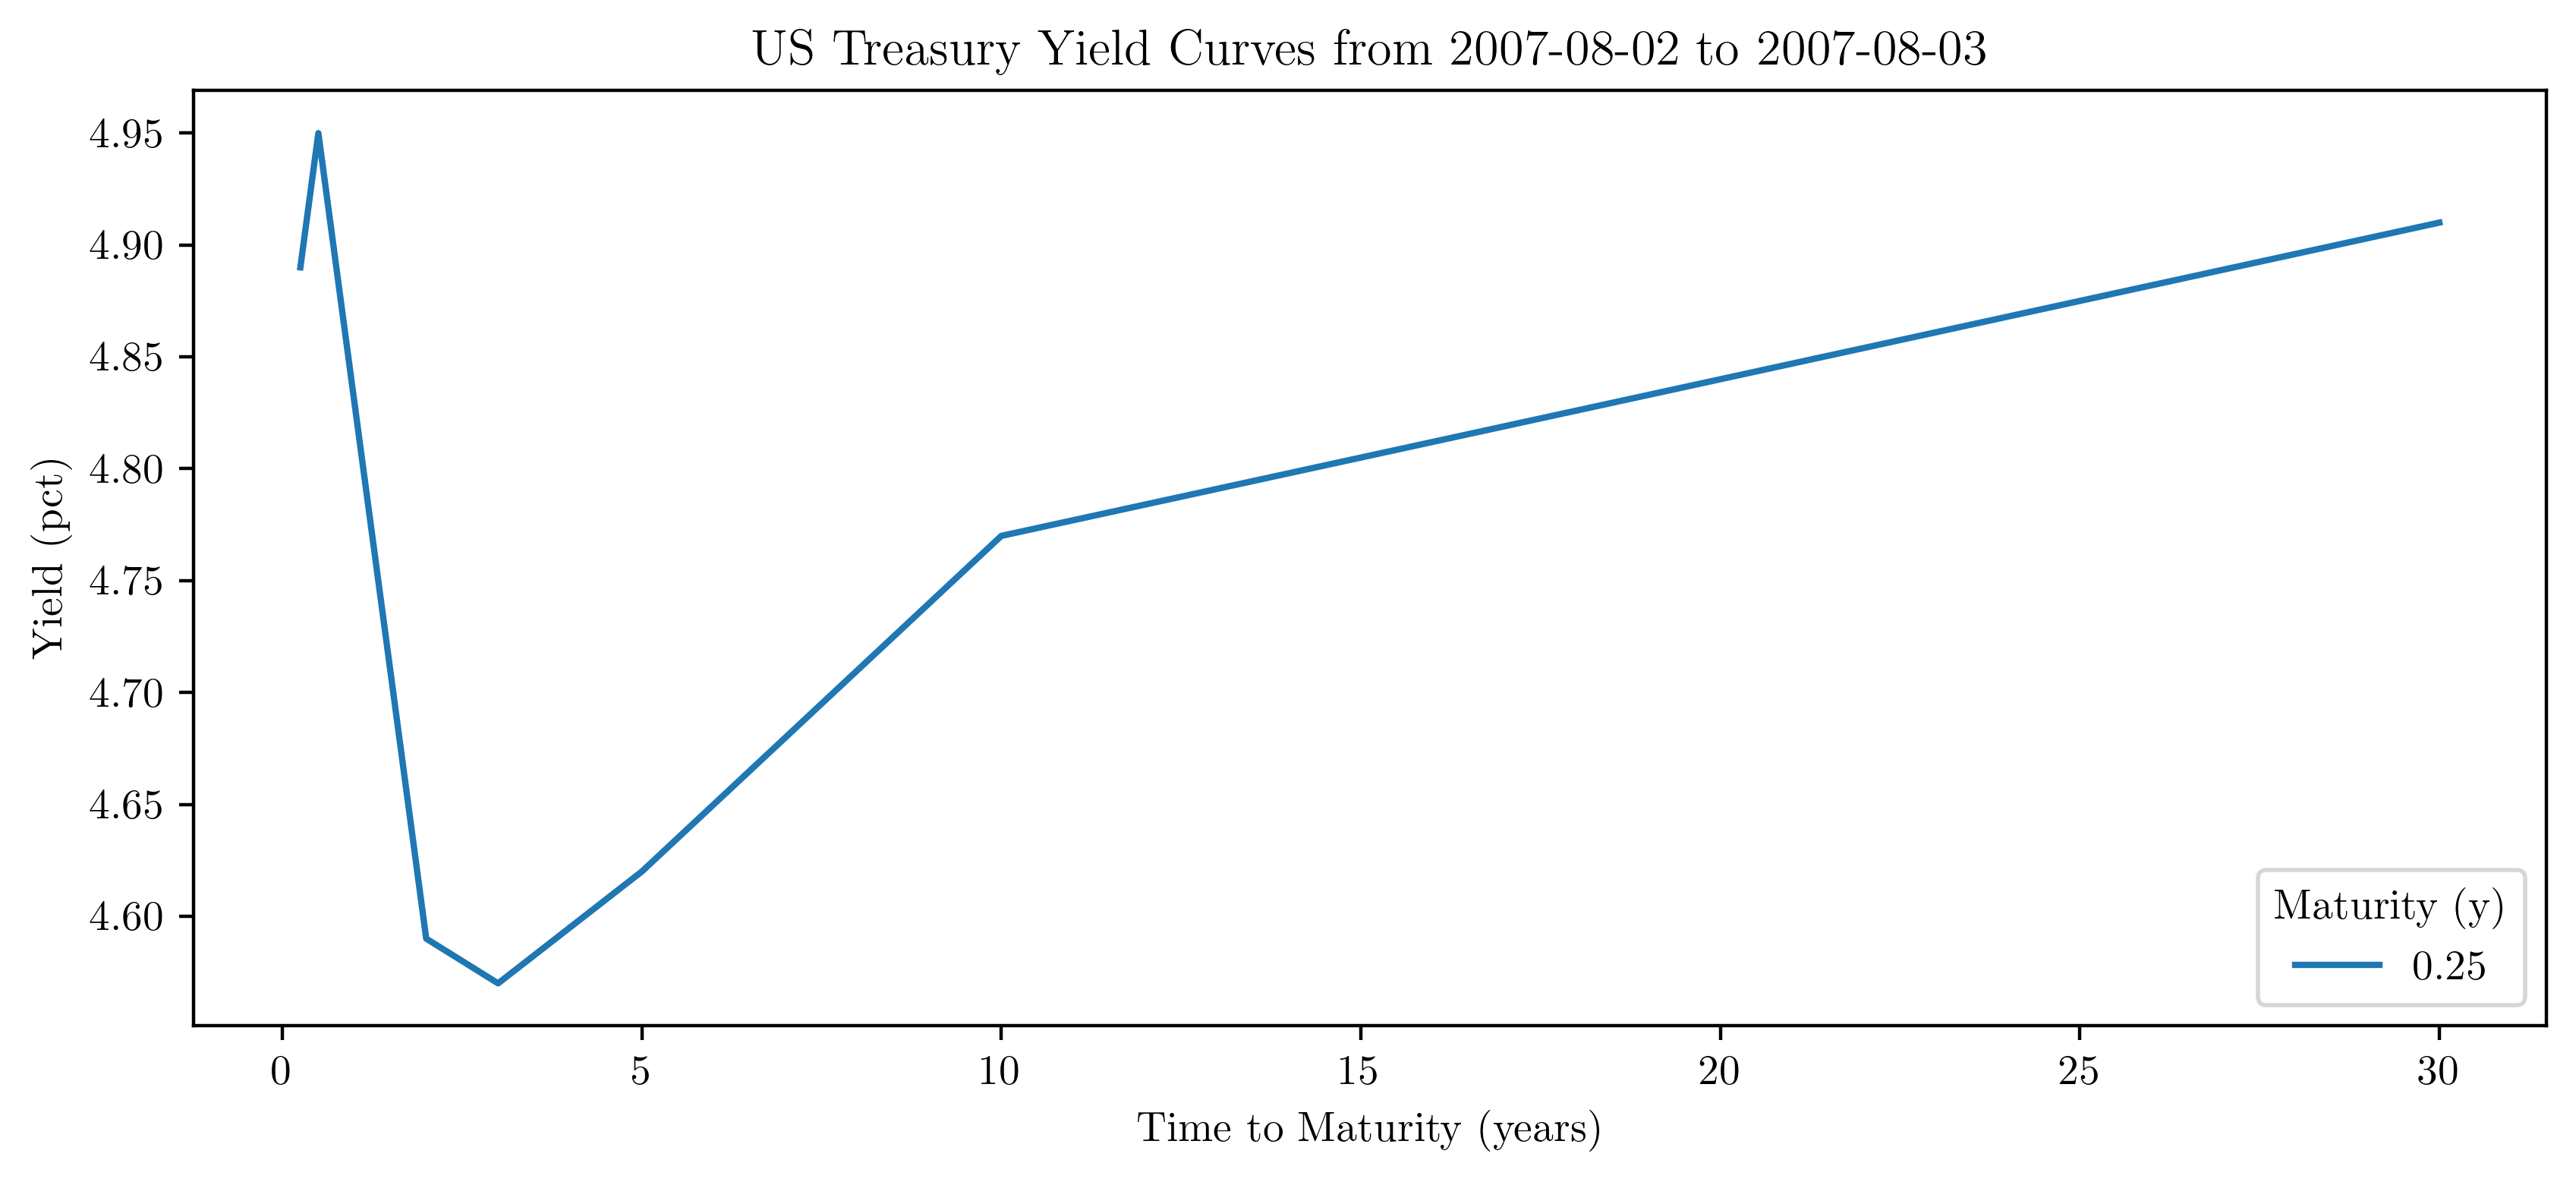

In [13]:
start_idx = 4400
num_curves = 1
end_idx = start_idx + num_curves

start_date: Timestamp = yield_curves.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = yield_curves.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(yield_curves.iloc[start_idx:end_idx].T)
plt.title(f"US Treasury Yield Curves from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (pct)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.show()

What is the distribution and moments of the 3 month vs 30y bonds? Why do you think that they differ?

## Duration and Convexity from the data

Scatter Plot 3 month returns against 2y, 10y, 30y. All on separate plots, here

I also want a way to plot convexity and duration here idk how

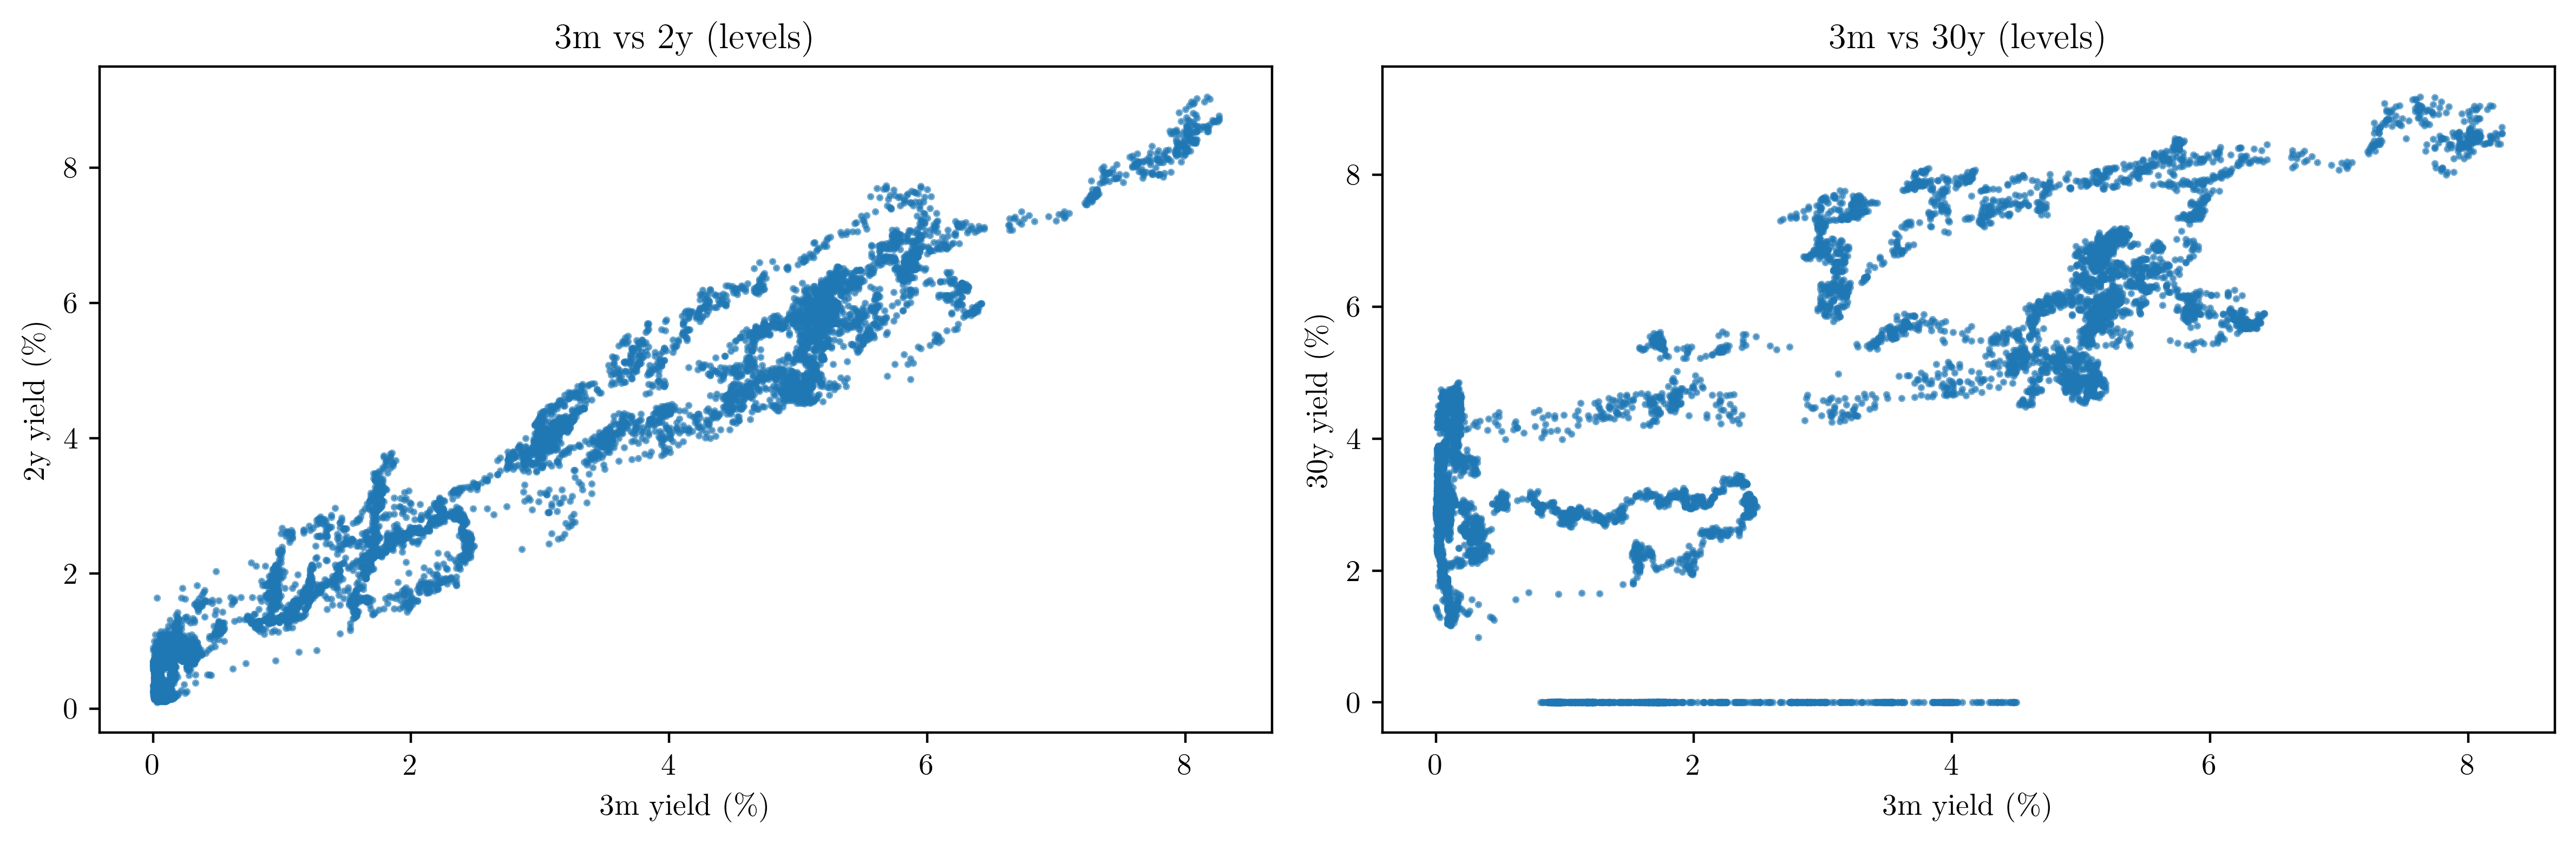

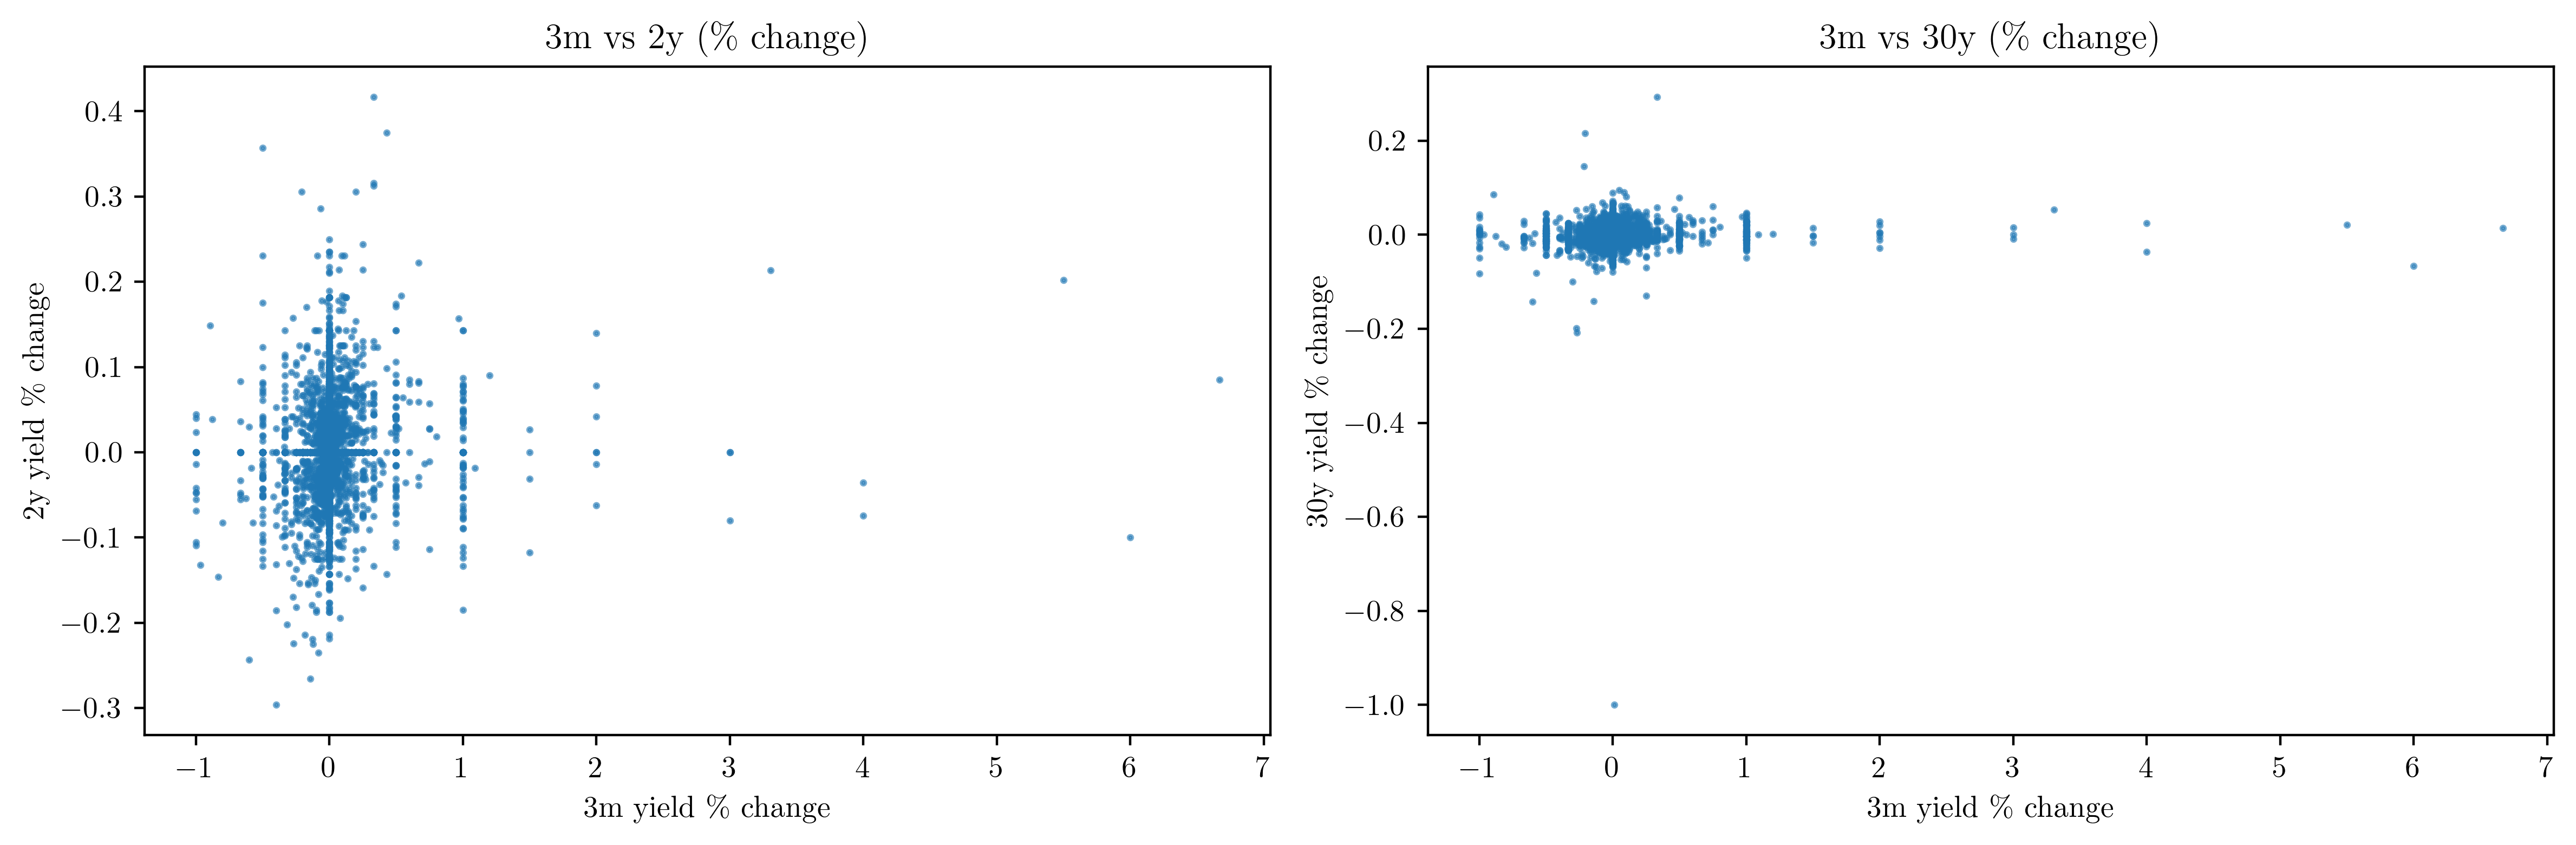

In [14]:
y3m = yield_curves[0.25]
y2 = yield_curves[2]
y30 = yield_curves[30]

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(y3m, y2, s=2, alpha=0.6)
ax1.set_xlabel("3m yield (\%)")
ax1.set_ylabel("2y yield (\%)")
ax1.set_title("3m vs 2y (levels)")
ax2.scatter(y3m, y30, s=2, alpha=0.6)
ax2.set_xlabel("3m yield (\%)")
ax2.set_ylabel("30y yield (\%)")
ax2.set_title("3m vs 30y (levels)")
plt.tight_layout()
plt.show()

pct3m = yield_curves[0.25].pct_change().dropna()
pct2 = yield_curves[2].pct_change().dropna()
pct30 = yield_curves[30].pct_change().dropna()
common = pct3m.index.intersection(pct2.index).intersection(pct30.index)
pct3m, pct2, pct30 = pct3m.loc[common], pct2.loc[common], pct30.loc[common]

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(pct3m, pct2, s=2, alpha=0.6)
ax1.set_xlabel("3m yield \% change")
ax1.set_ylabel("2y yield \% change")
ax1.set_title("3m vs 2y (\% change)")
ax2.scatter(pct3m, pct30, s=2, alpha=0.6)
ax2.set_xlabel("3m yield \% change")
ax2.set_ylabel("30y yield \% change")
ax2.set_title("3m vs 30y (\% change)")
plt.tight_layout()
plt.show()

Are the for quarters of this plot: (+,+), (+, -), (-,+), (-,-) perfectly symmetrical? Is there any "edge" that we can obtain from these plots?

## Initial Exploration

Correlation plot gives us a good way to start on the structure of the data.

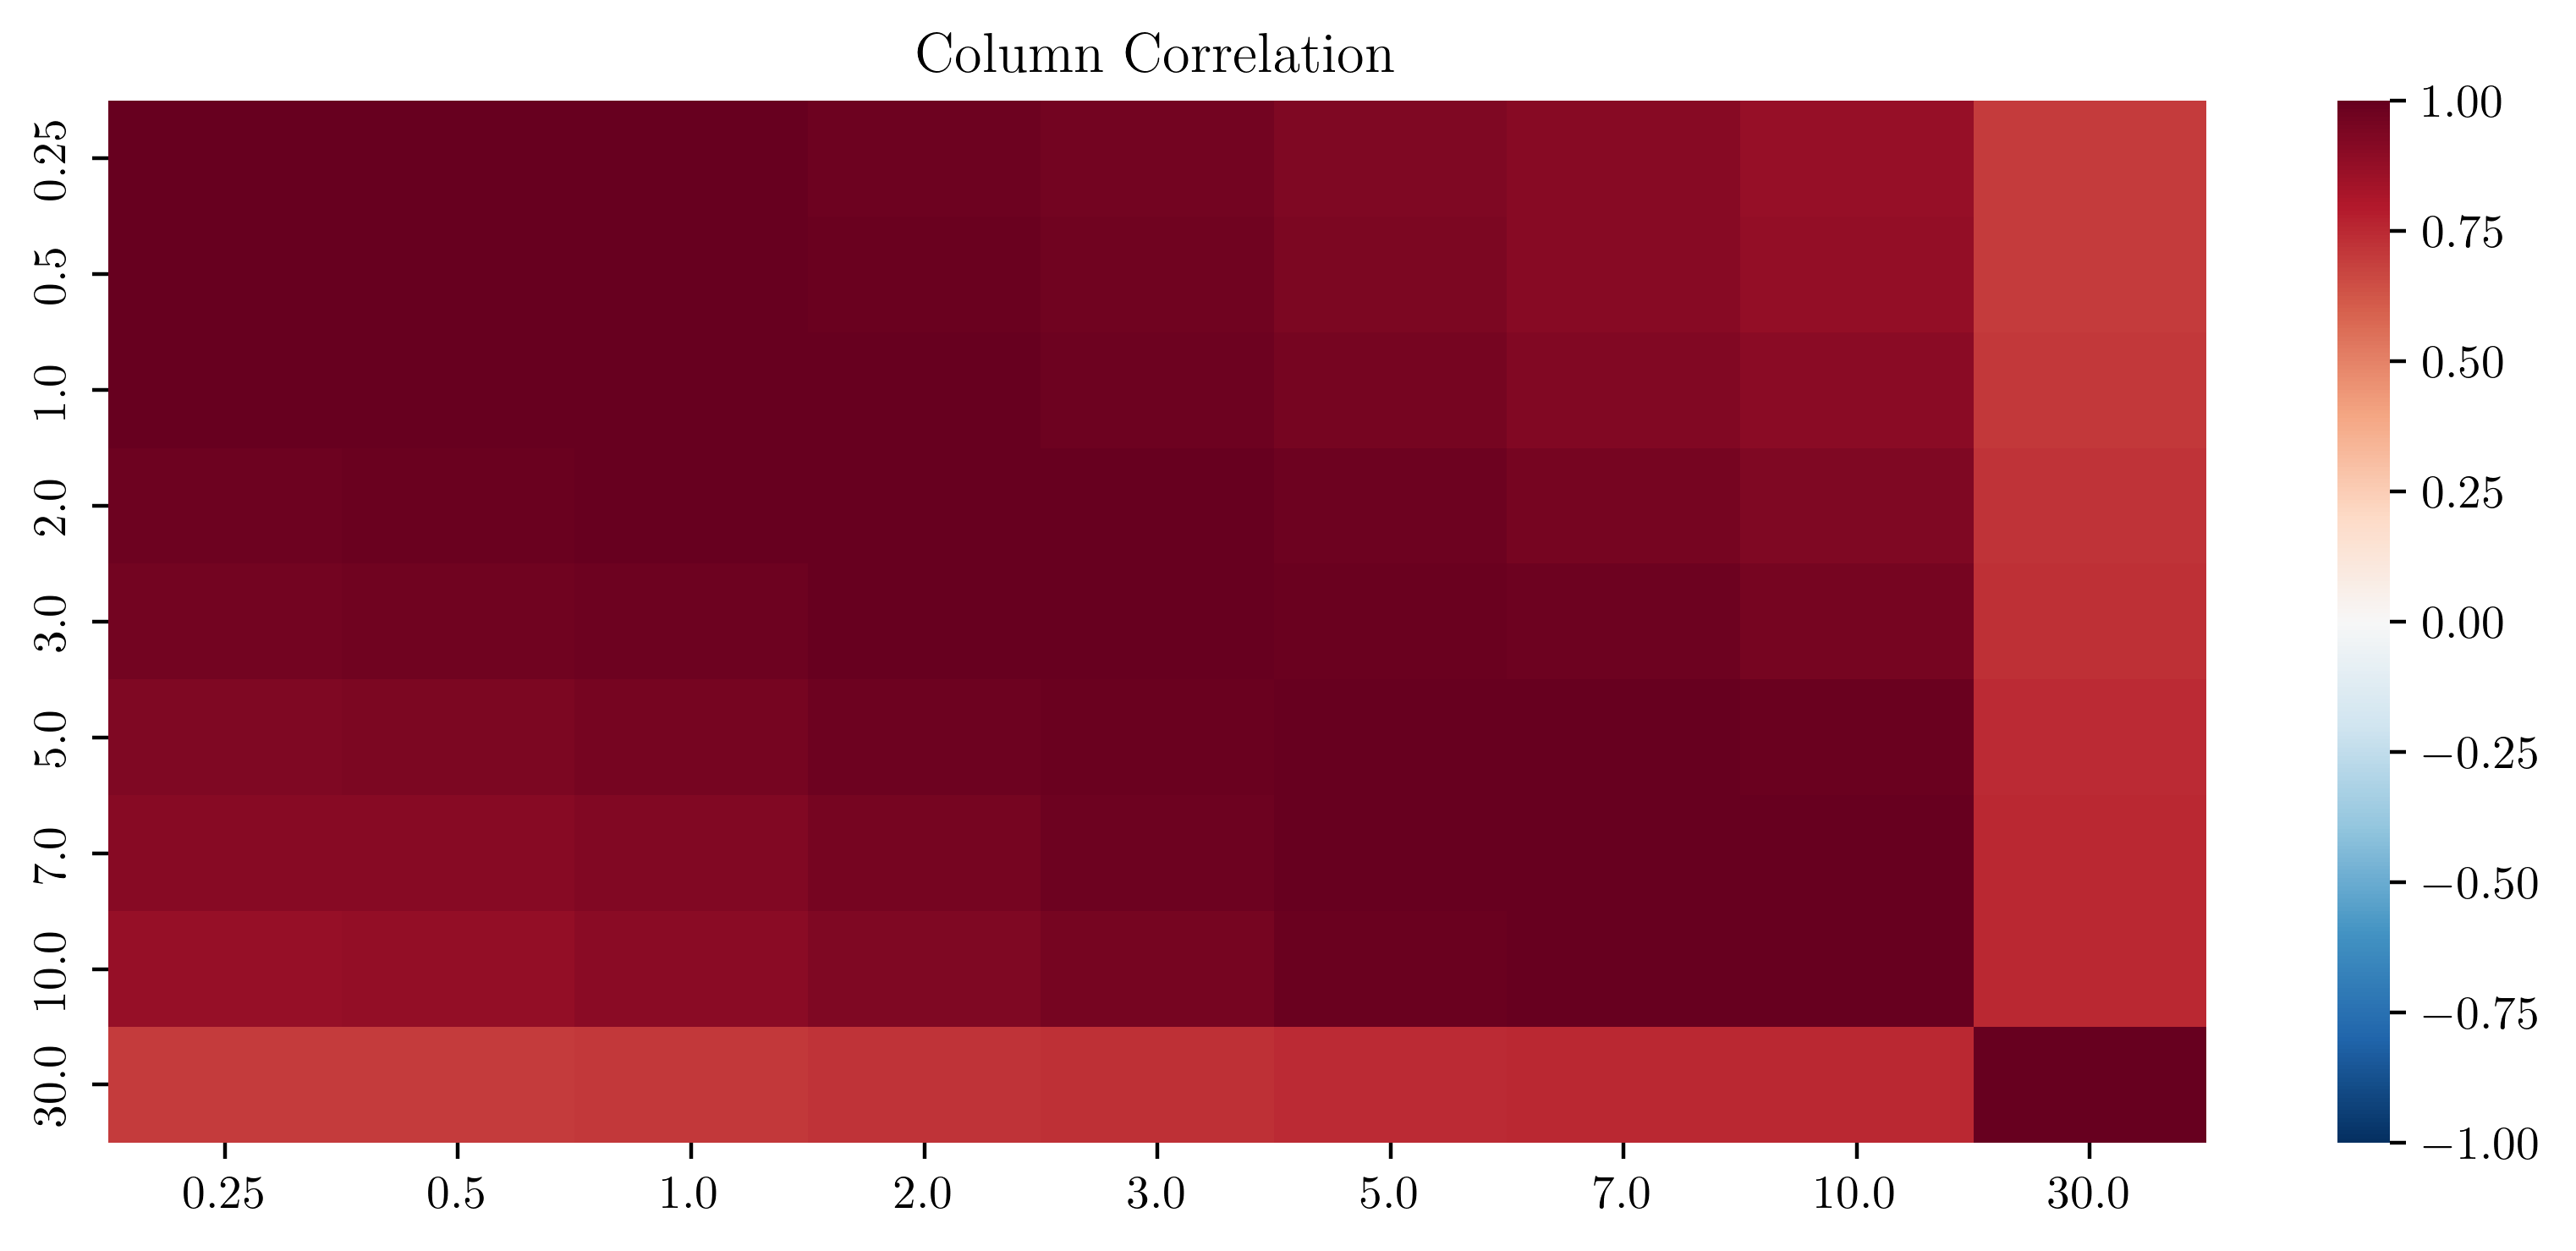

In [15]:
sns.heatmap(yield_curves.select_dtypes(include="number").corr(), cmap="RdBu_r", vmin=-1, vmax=1)
plt.title("Column Correlation")
plt.show()

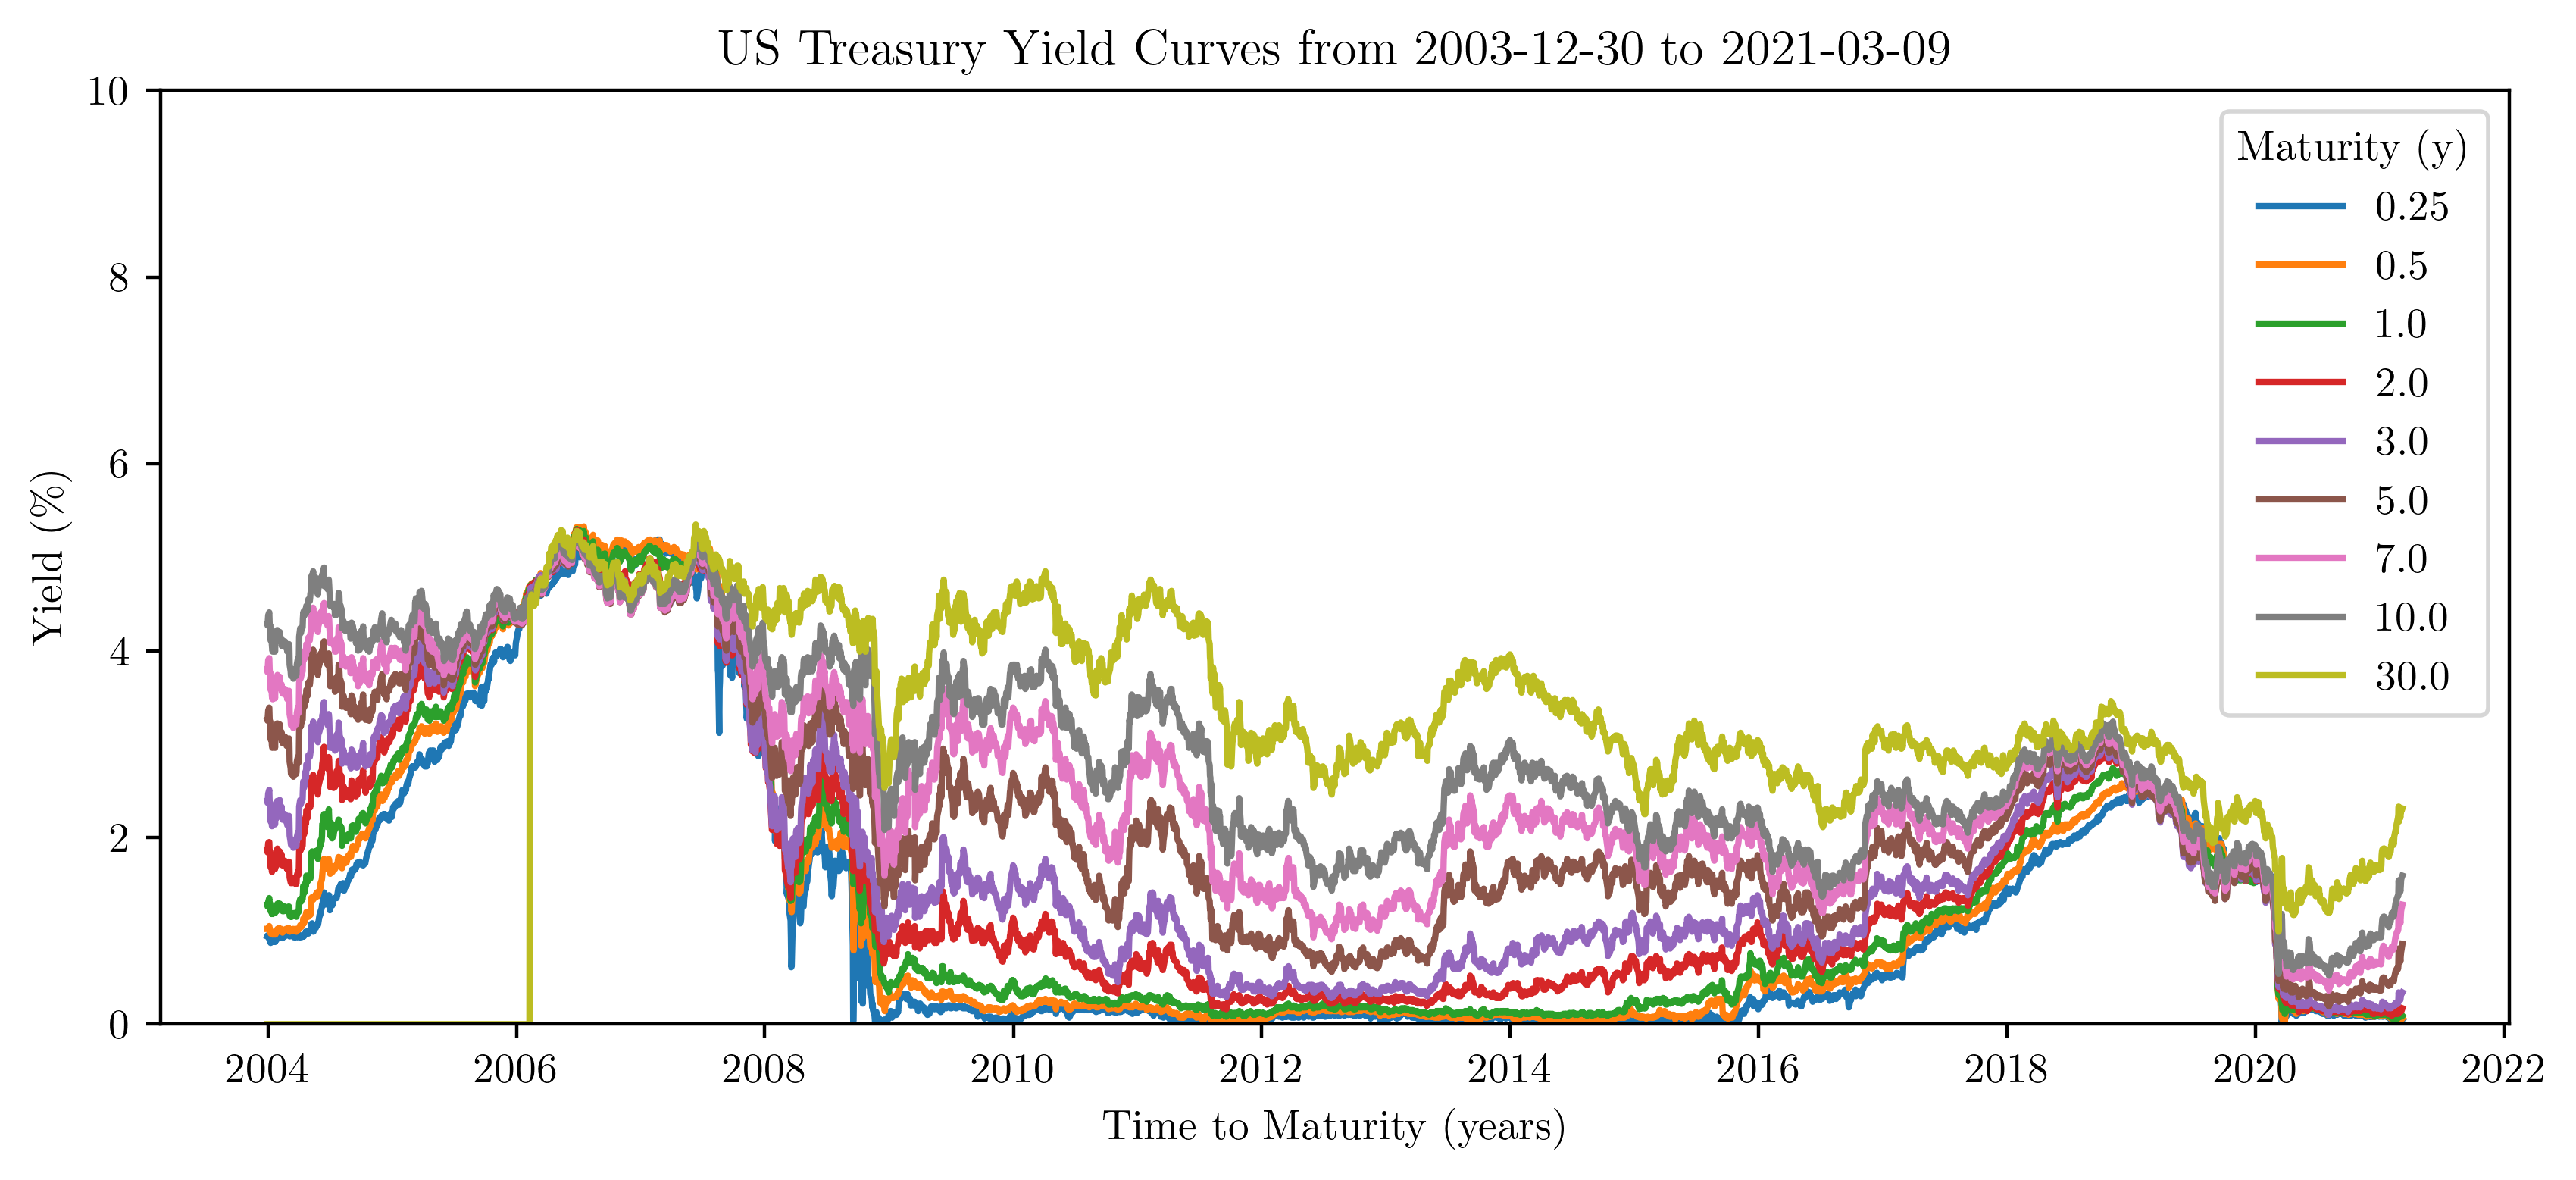

In [16]:
start_idx = 4400 - 900
num_curves = 4300
end_idx = start_idx + num_curves

start_date: Timestamp = yield_curves.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = yield_curves.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(yield_curves.iloc[start_idx:end_idx])
plt.title(f"US Treasury Yield Curves from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (\%)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.ylim(0, 10)
plt.show()

How do Yield Curves react to market shocks? What is the relationship between Yield Curve volatility and shocks?

Next information:
- Plot rolling vol, and rolling vol correlation
- MR property relative to RF rate according to literature models

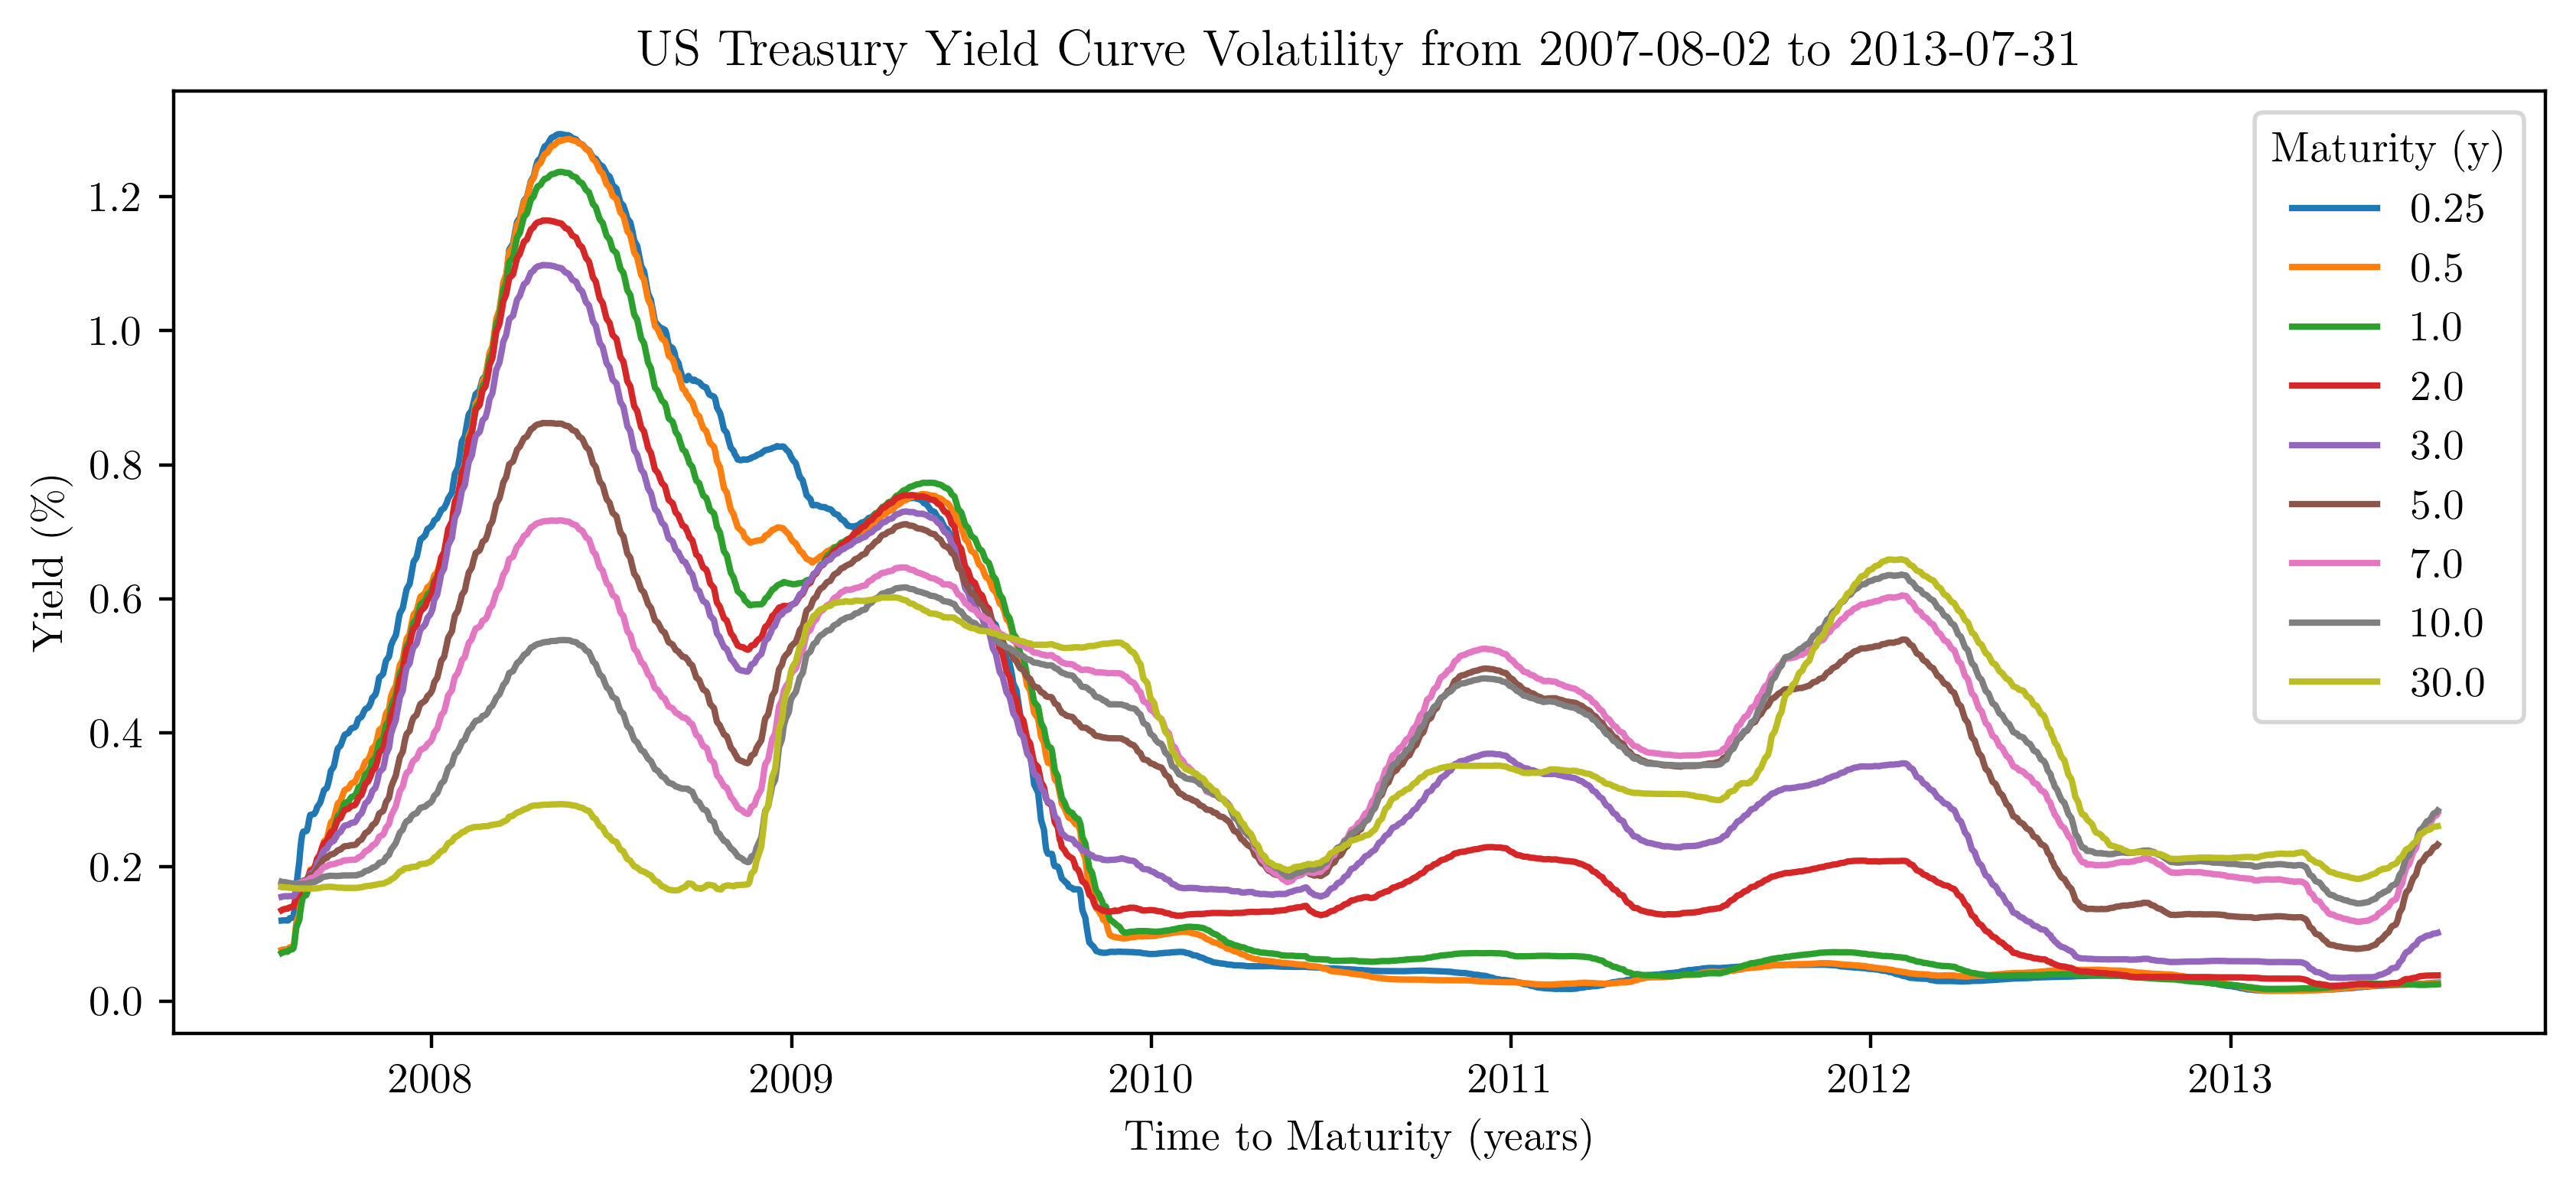

In [17]:
start_idx = 4400 
num_curves = 1500
end_idx = start_idx + num_curves
rolling_vol = yield_curves.rolling(252).std()

start_date: Timestamp = rolling_vol.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = rolling_vol.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(rolling_vol.iloc[start_idx:end_idx])
plt.title(f"US Treasury Yield Curve Volatility from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (\%)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.show()

### TODO

Add a volatility heatmap, then do a `abs(vol_heatmap - yields_heatmap)` volatility plot which shows where they differ.

## What is the structure of yields and volatility?

We can use Machine Learning in order to understand the structure of yield curves and volatility. We can compare whether or not they are similar


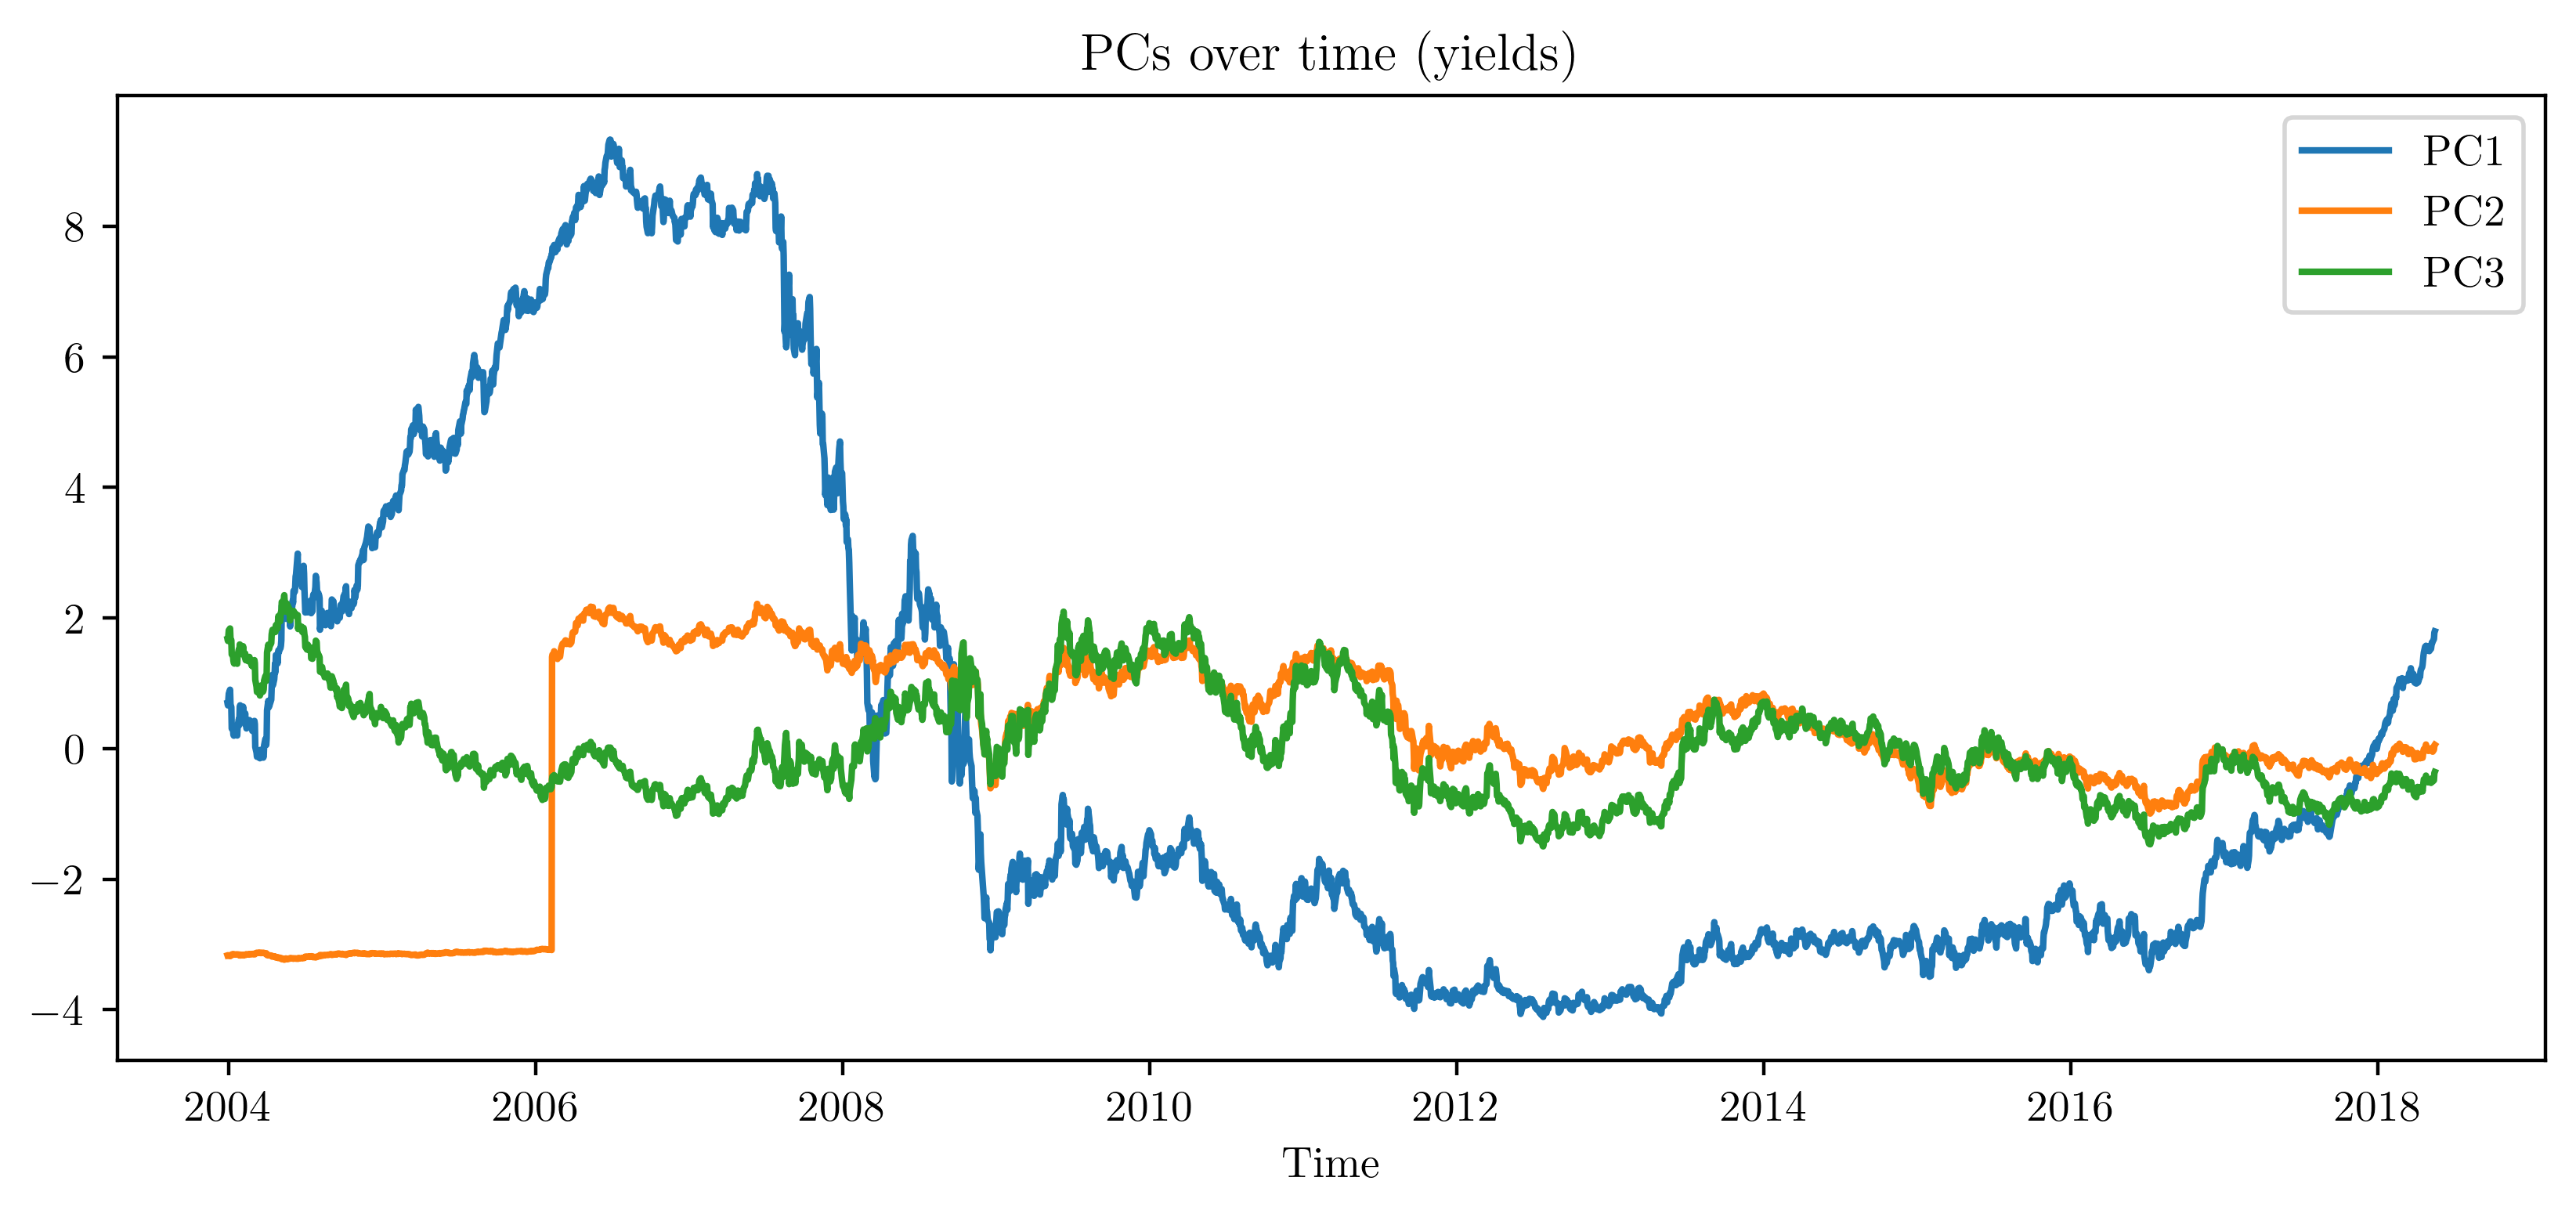

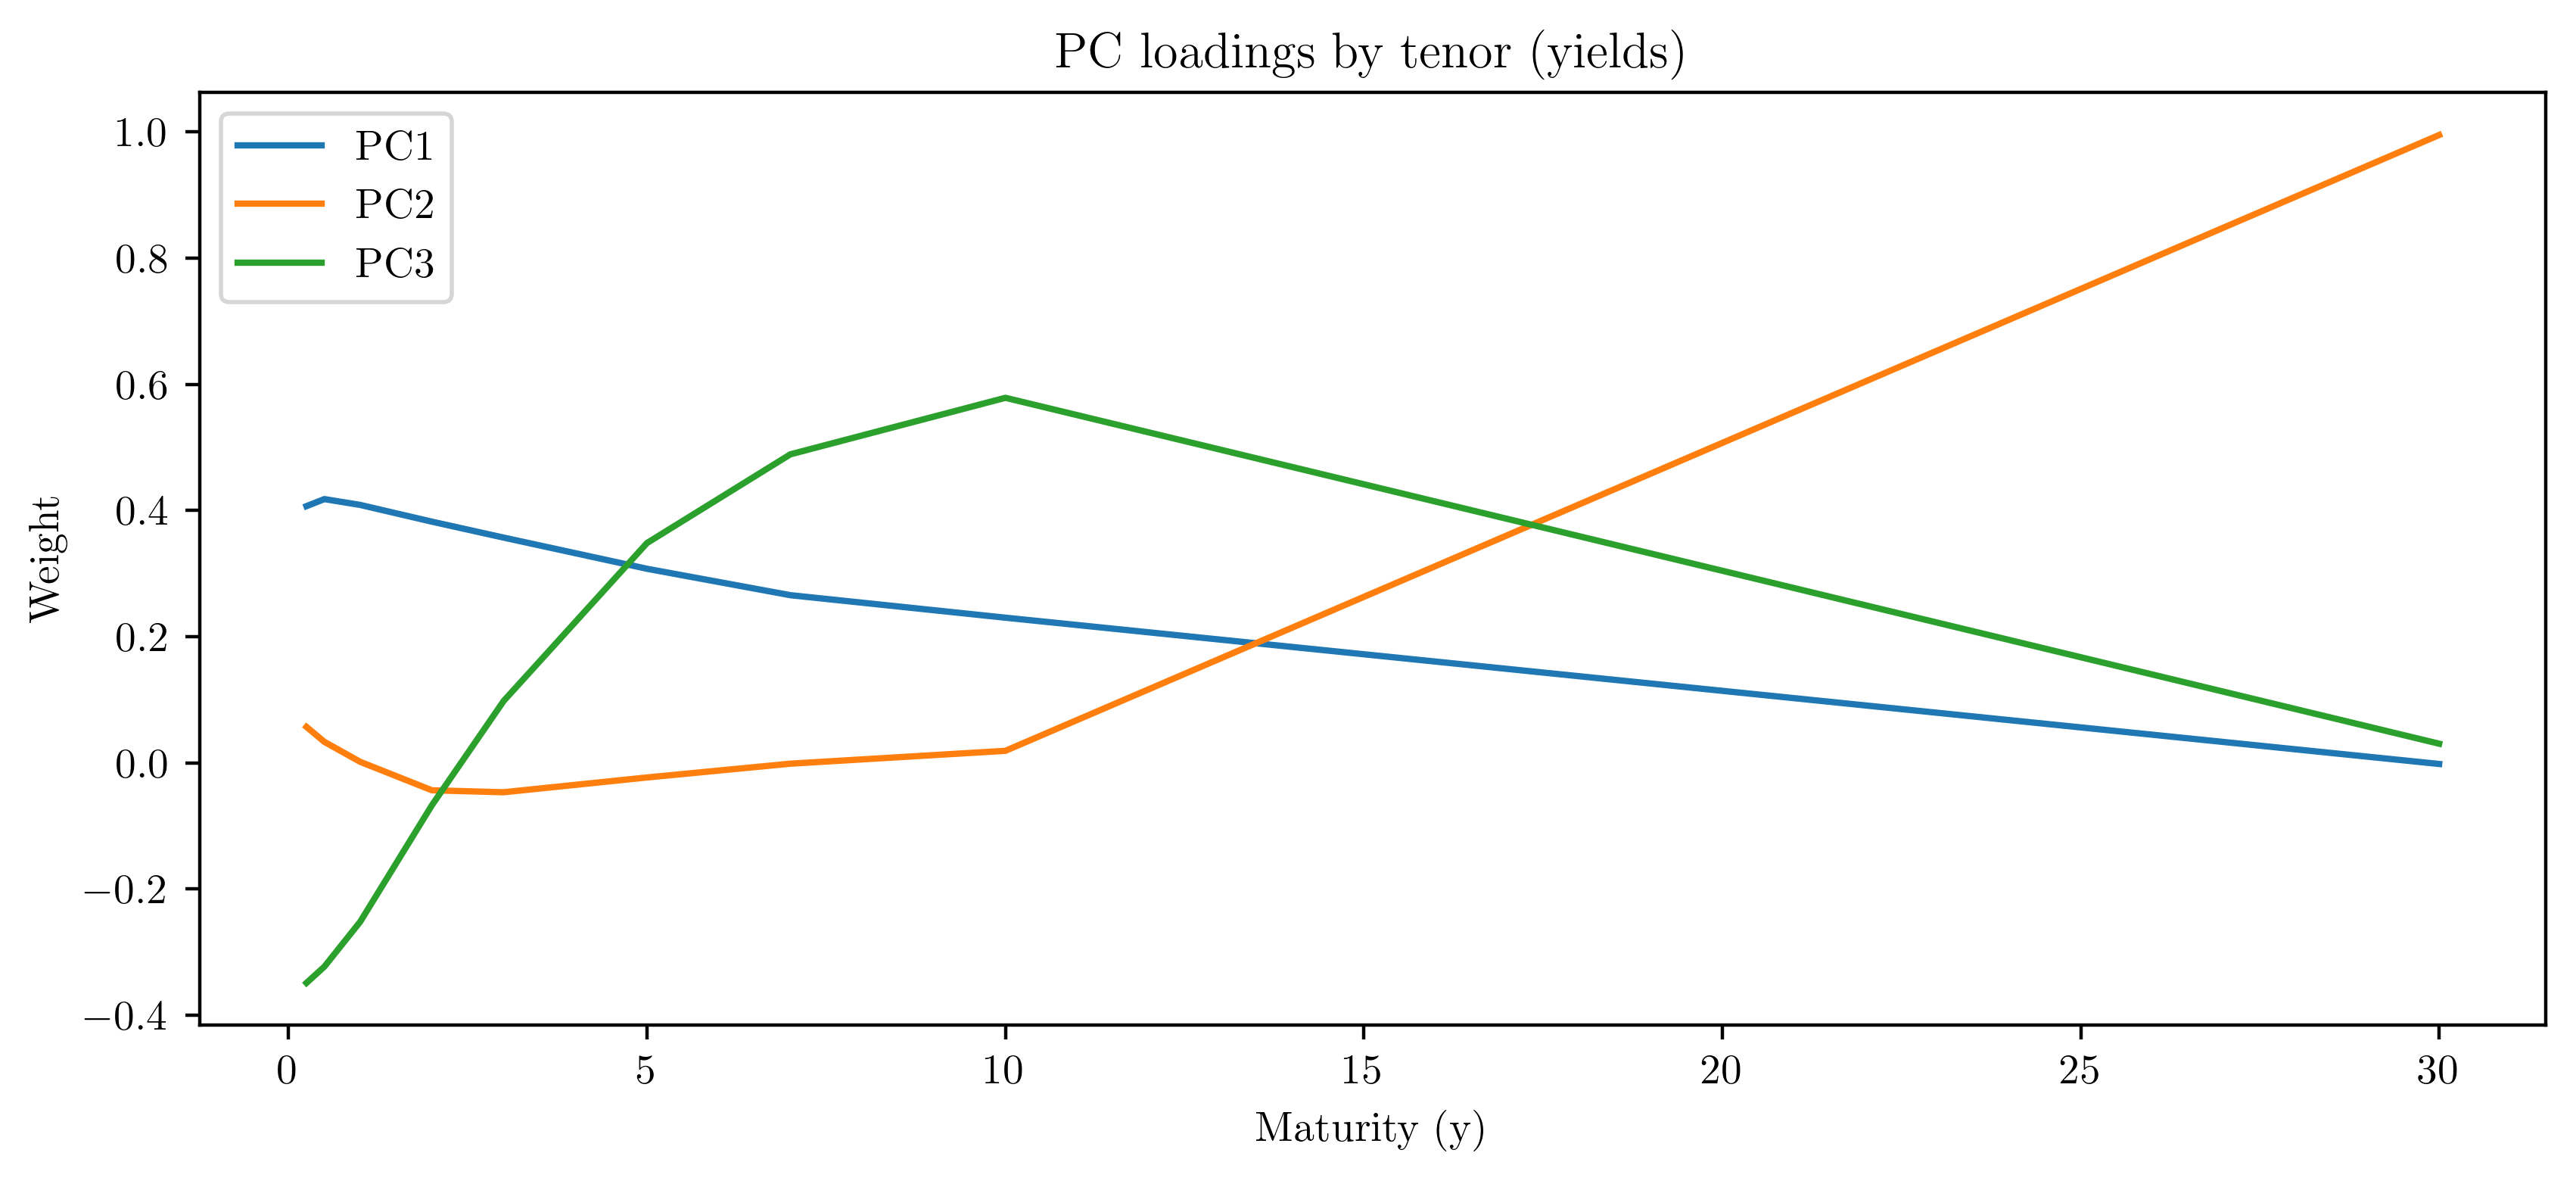

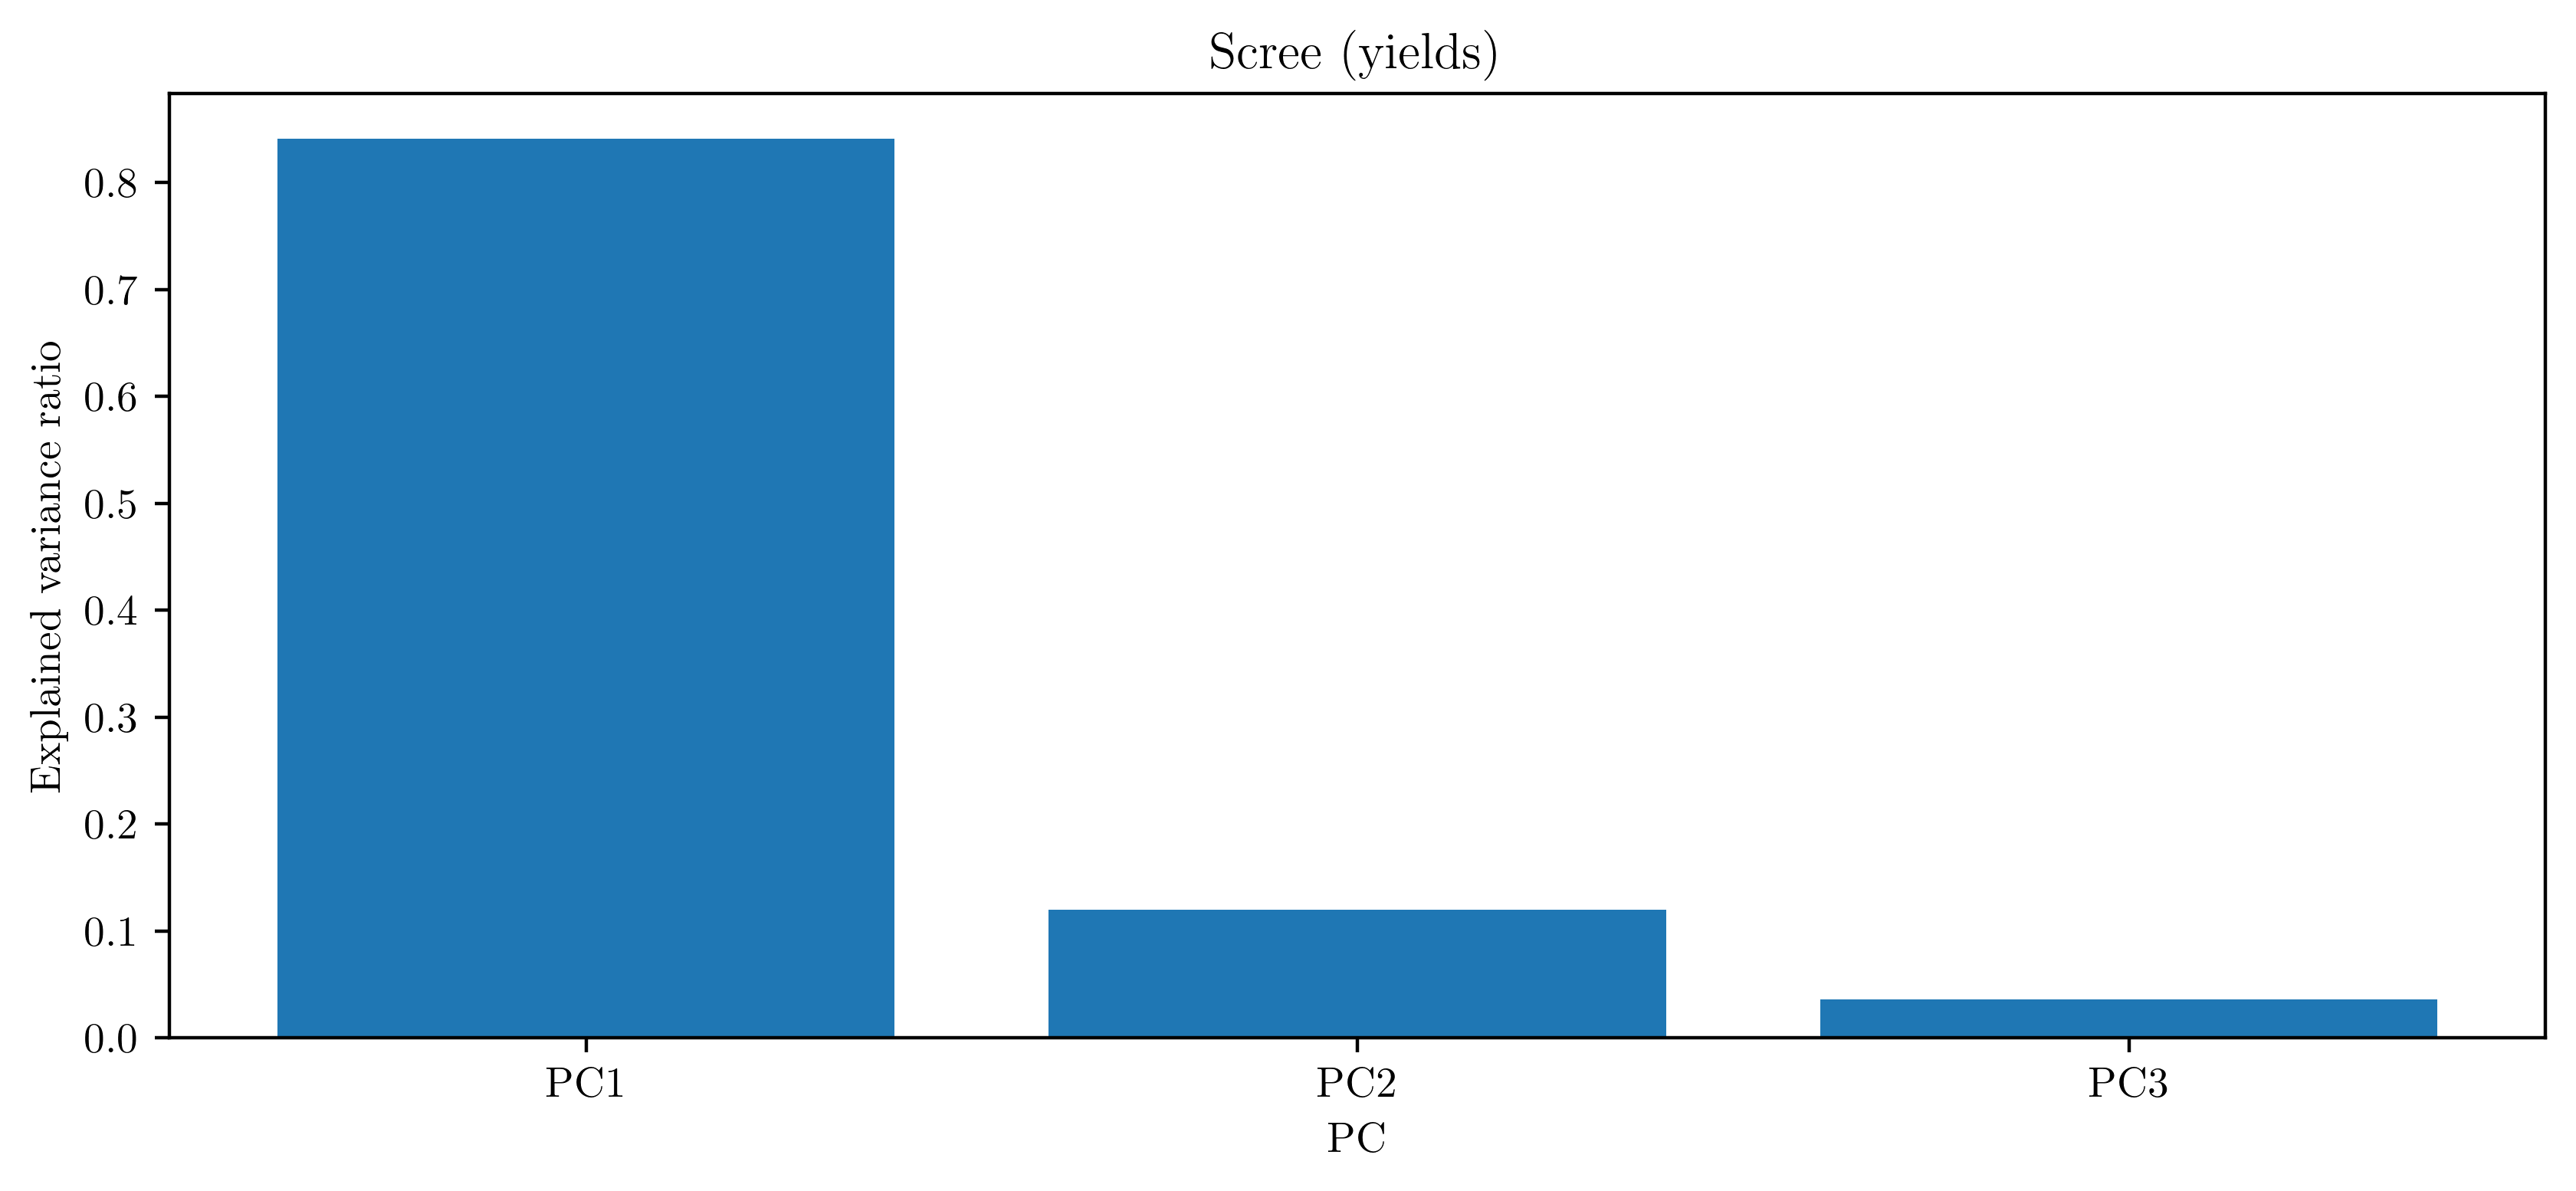

In [18]:
from sklearn.decomposition import PCA

start_idx = 4400 - 900
num_curves = 3600
end_idx = start_idx + num_curves
X = yield_curves.iloc[start_idx:end_idx]
pca = PCA(n_components=3).fit(X)
scores = pca.transform(X)

plt.figure()
plt.plot(X.index, scores)
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time")
plt.title("PCs over time (yields)")
plt.show()

plt.figure()
for i in range(3):
    plt.plot(X.columns, pca.components_[i], label=f"PC{i+1}")
plt.xlabel("Maturity (y)")
plt.ylabel("Weight")
plt.legend()
plt.title("PC loadings by tenor (yields)")
plt.show()

plt.figure()
plt.bar([1, 2, 3], pca.explained_variance_ratio_)
plt.xticks([1, 2, 3], ["PC1", "PC2", "PC3"])
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.title("Scree (yields)")
plt.show()

In [19]:
pca.explained_variance_ratio_.cumsum()

array([0.84096068, 0.96079808, 0.99671691])

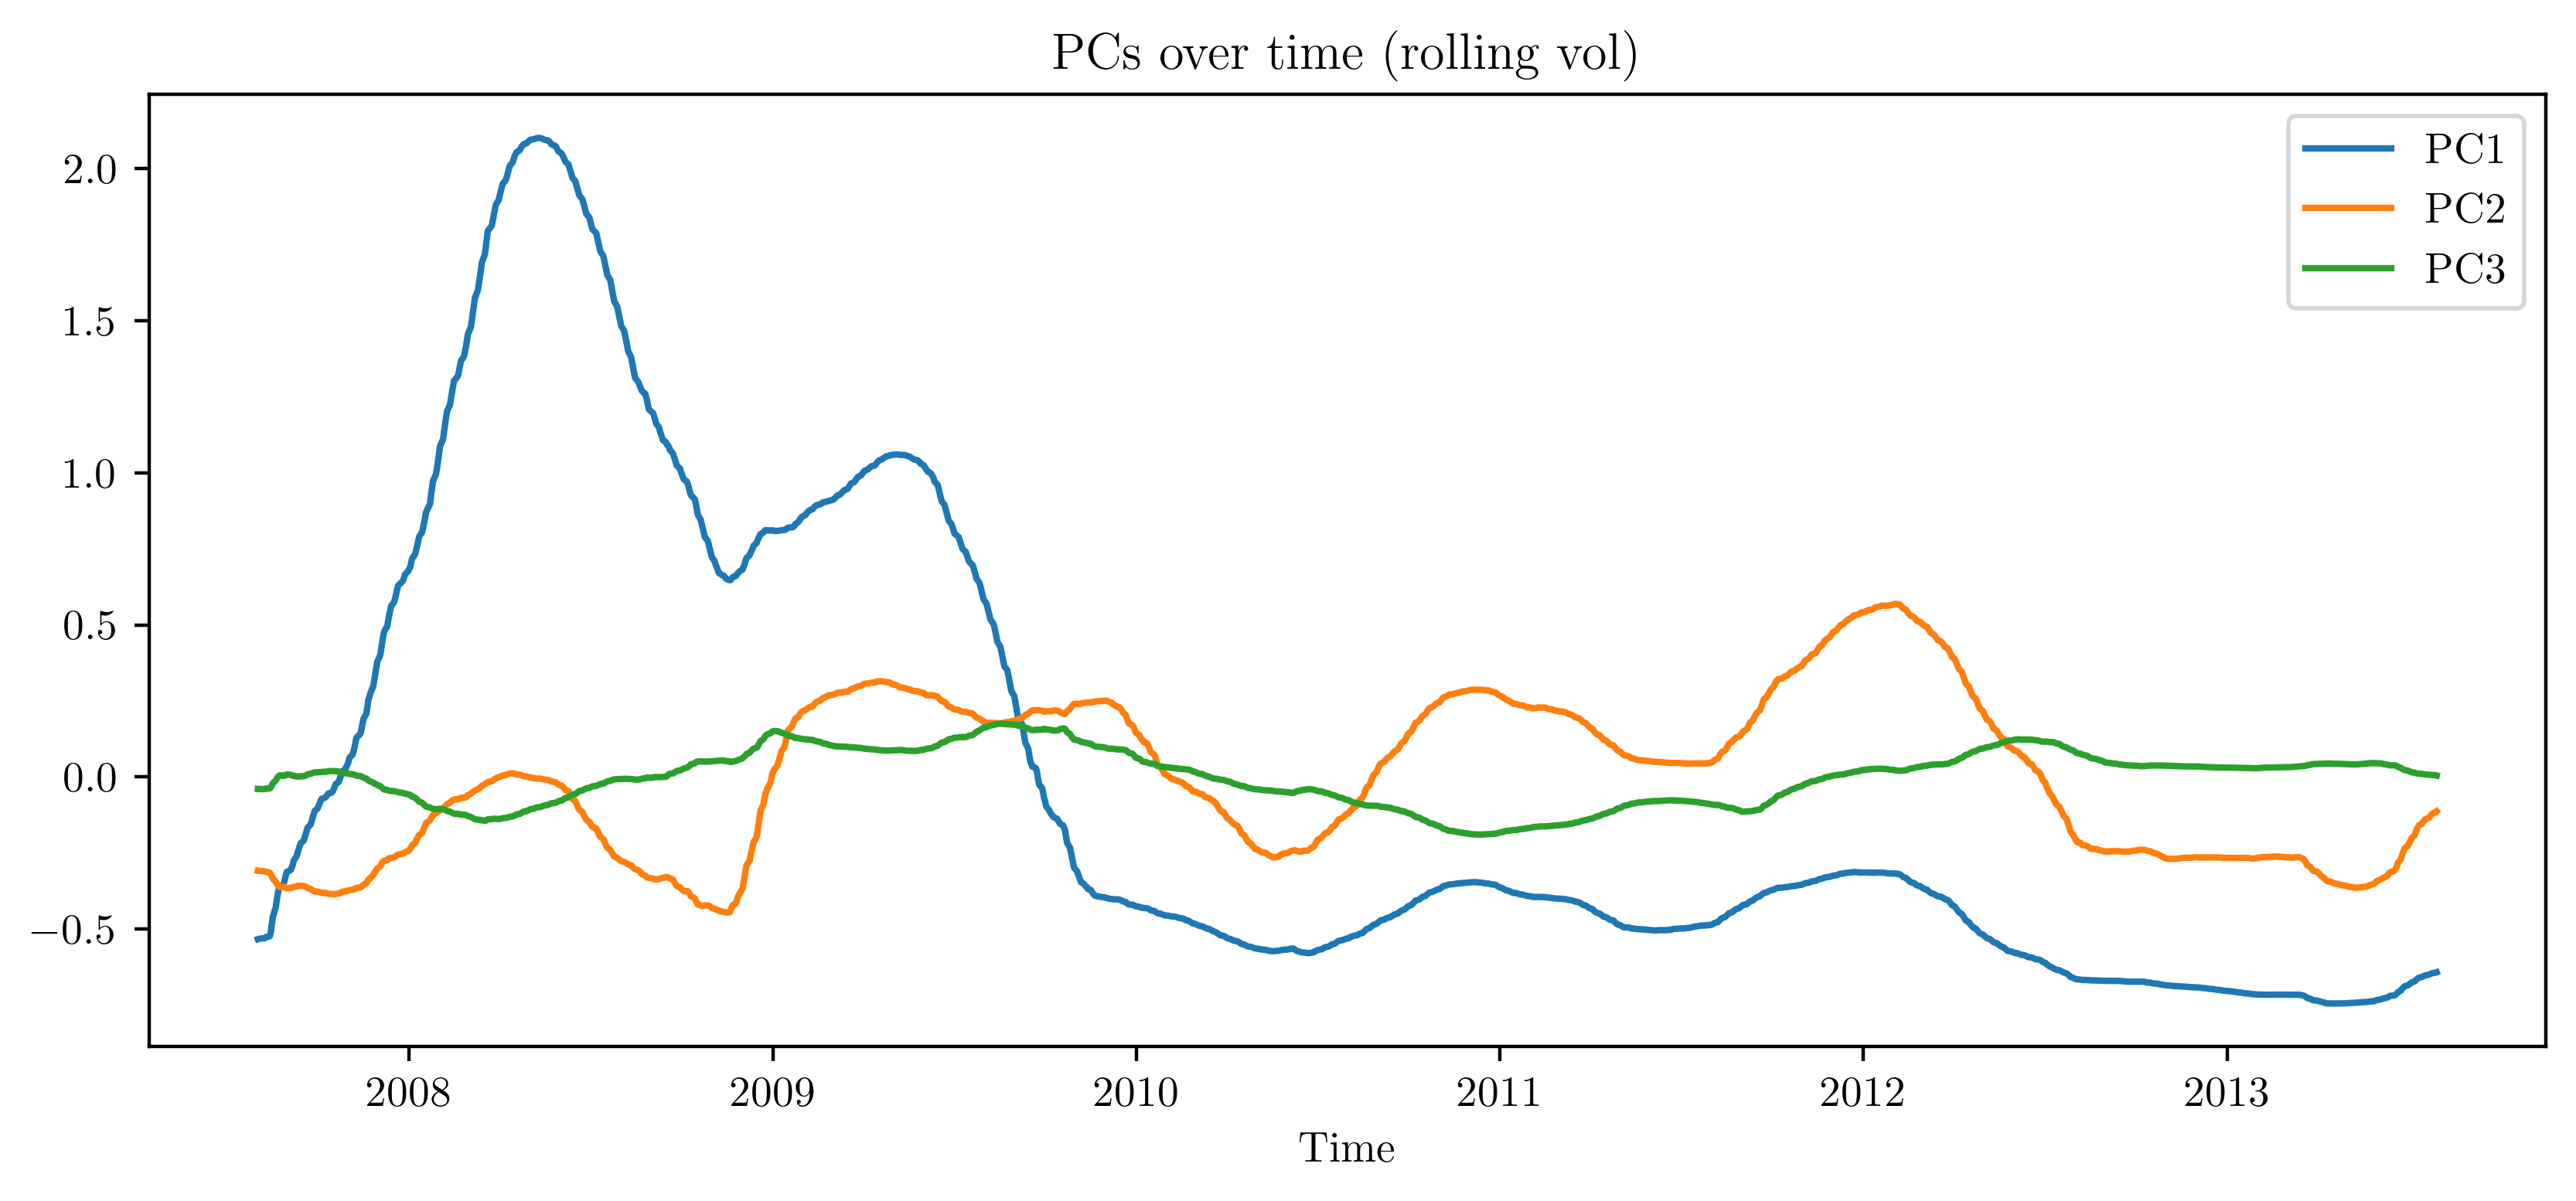

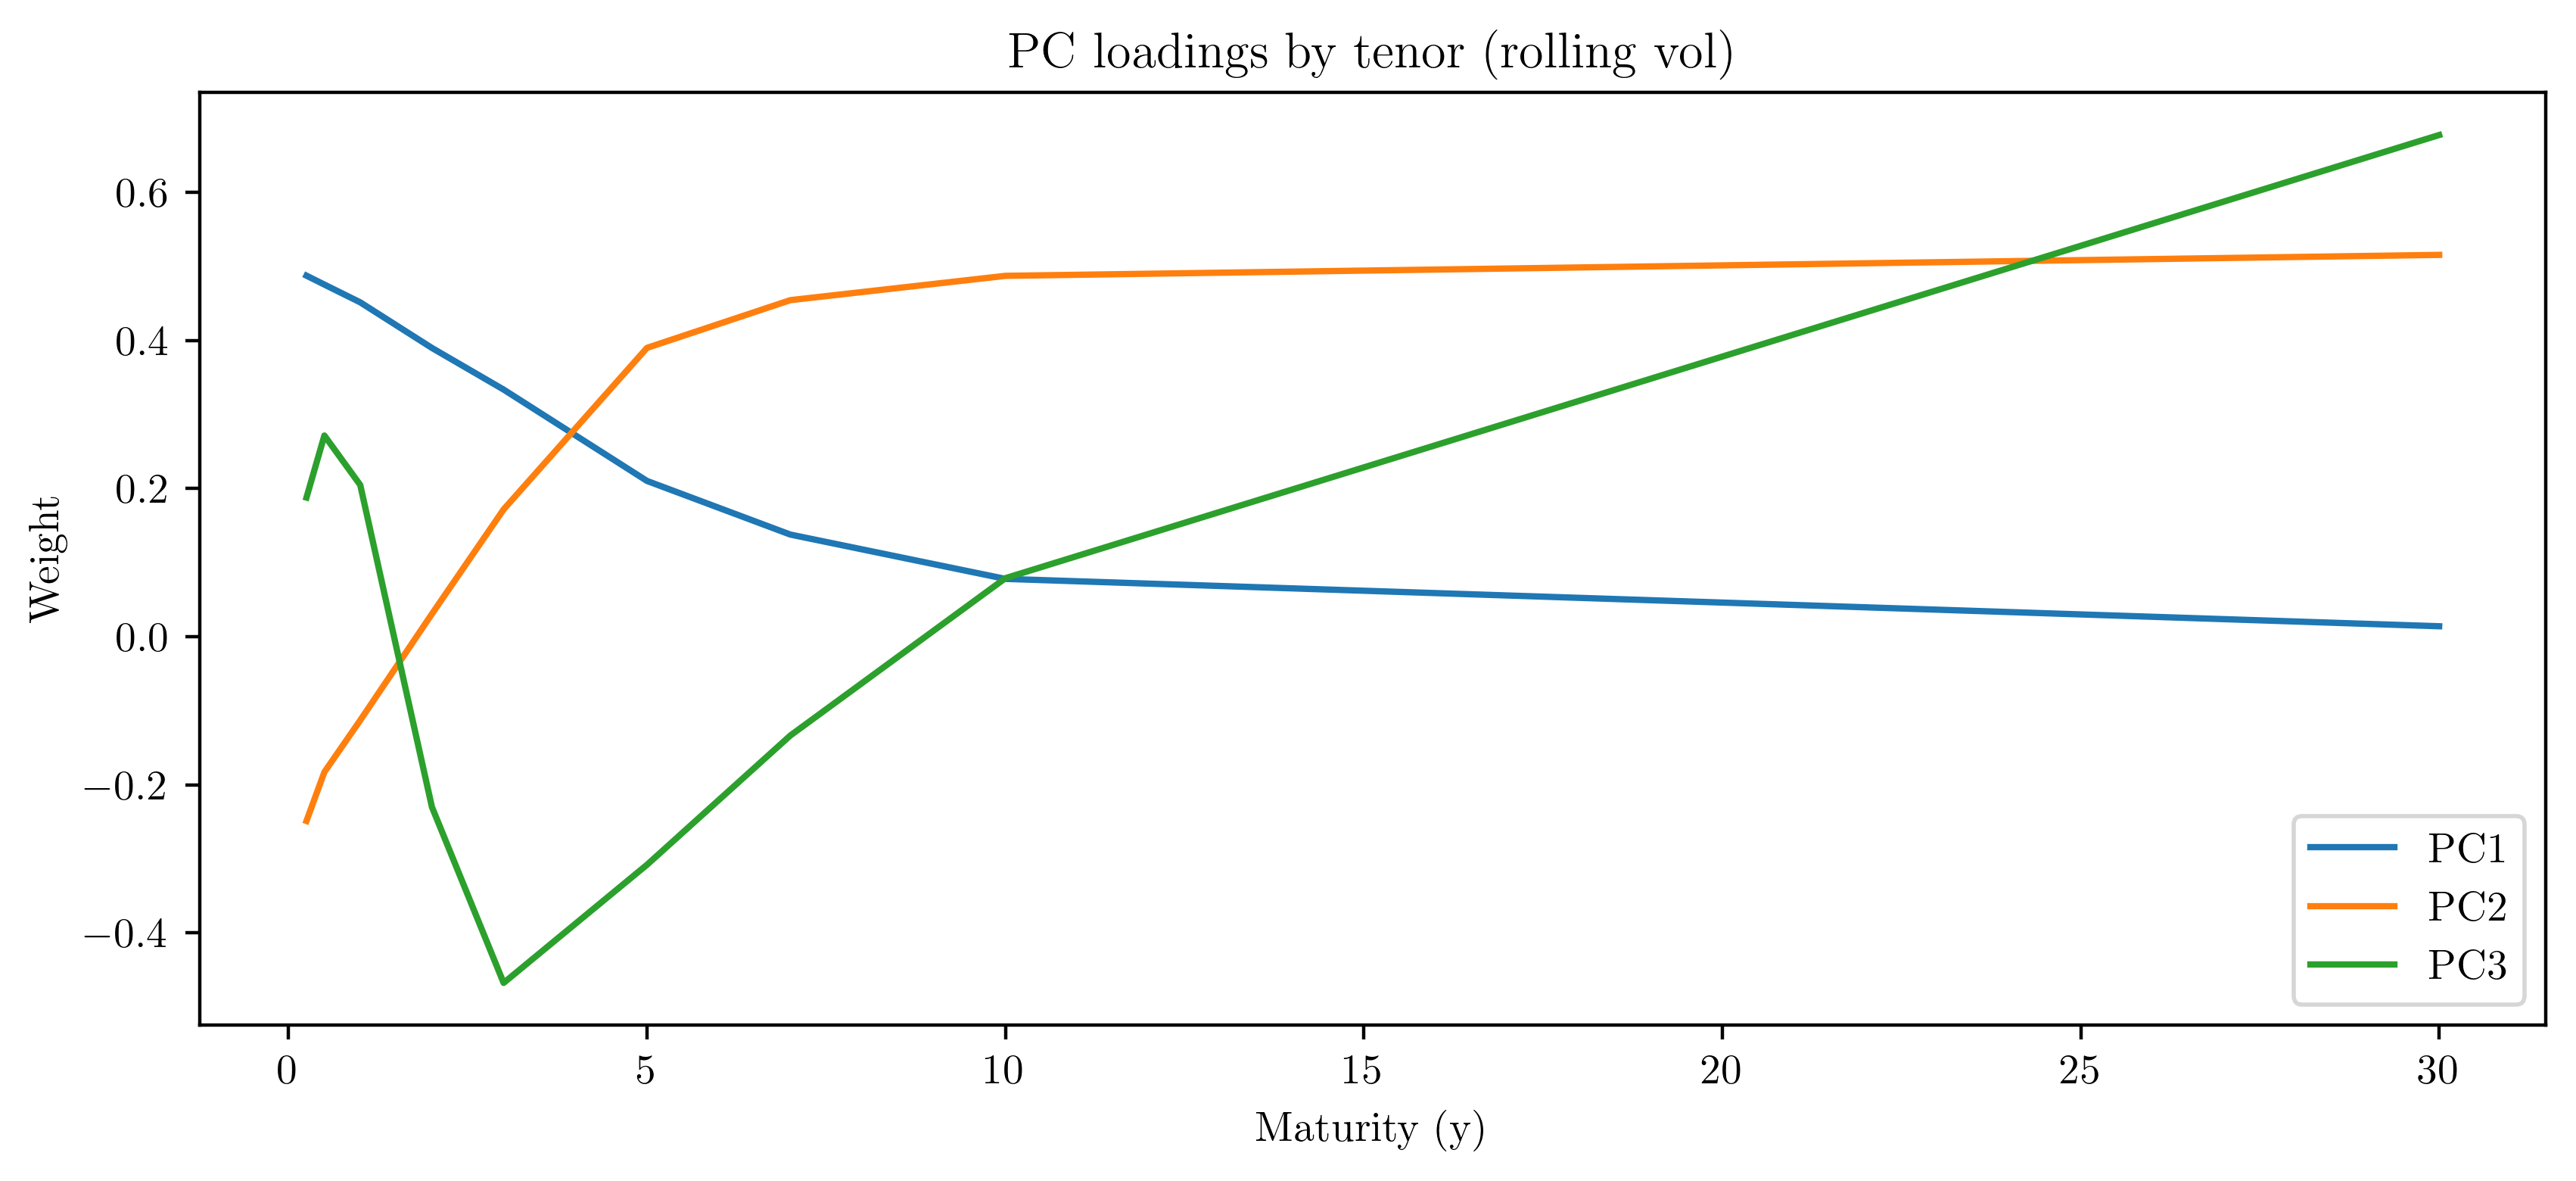

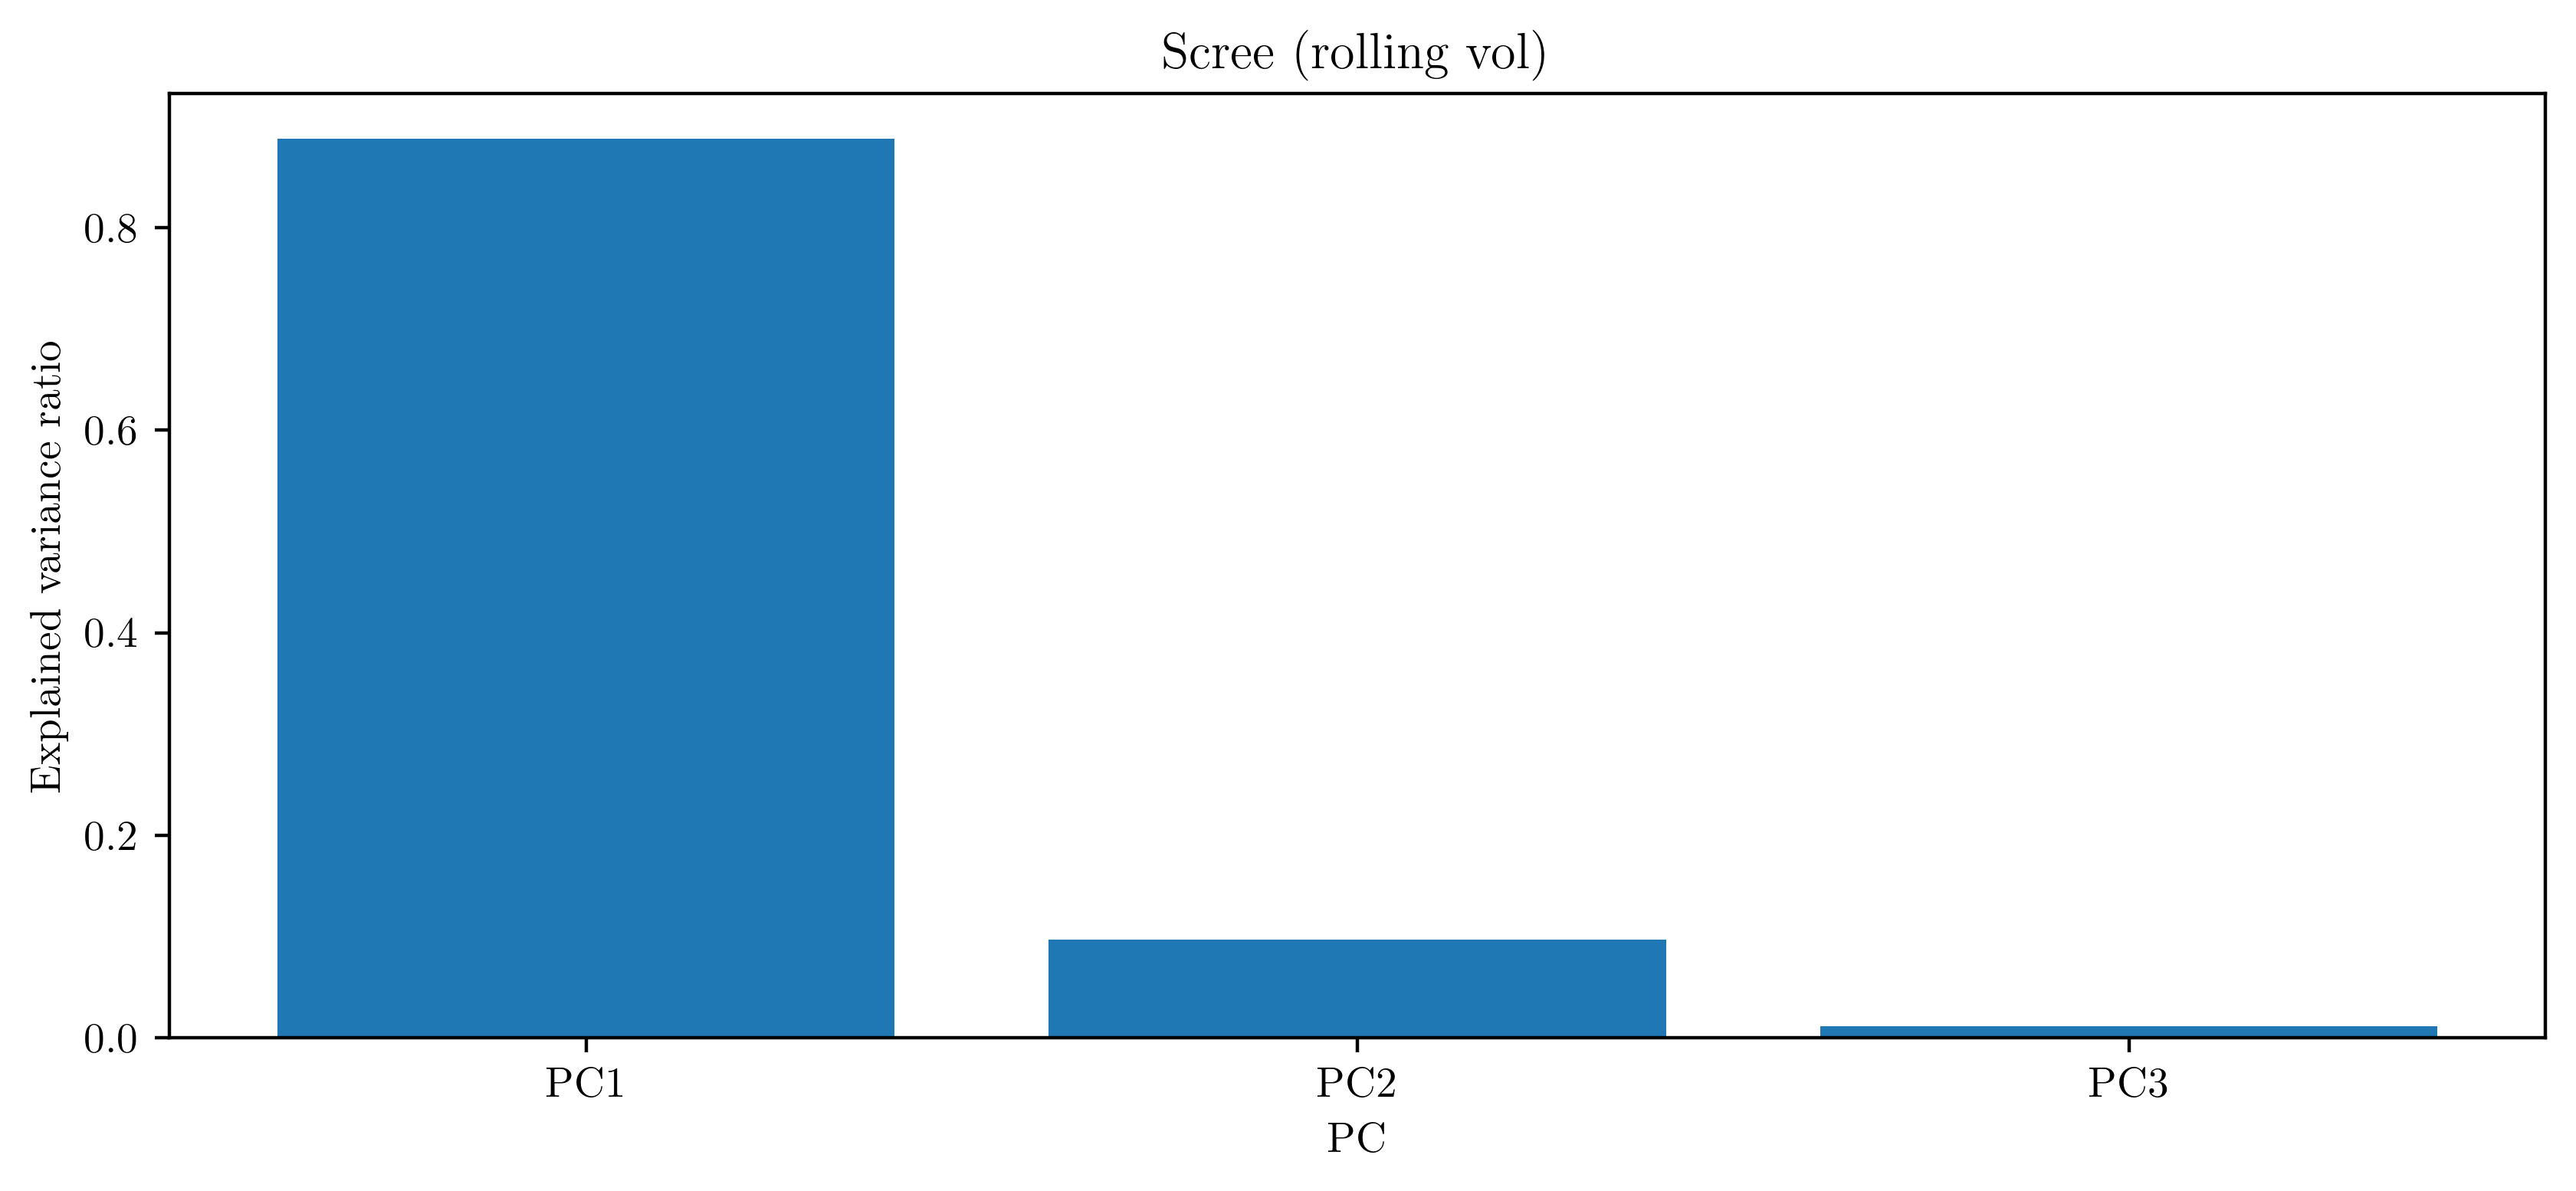

In [20]:
from sklearn.decomposition import PCA

rolling_vol = yield_curves.rolling(252).std()
vol_start_idx = 4400
vol_num_curves = 1500
vol_end_idx = vol_start_idx + vol_num_curves
vol_X = rolling_vol.iloc[vol_start_idx:vol_end_idx].dropna(axis=0)
vol_pca = PCA(n_components=3).fit(vol_X)
vol_scores = vol_pca.transform(vol_X)

plt.figure()
plt.plot(vol_X.index, vol_scores)
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time")
plt.title("PCs over time (rolling vol)")
plt.show()

plt.figure()
for i in range(3):
    plt.plot(vol_X.columns, vol_pca.components_[i], label=f"PC{i+1}")
plt.xlabel("Maturity (y)")
plt.ylabel("Weight")
plt.legend()
plt.title("PC loadings by tenor (rolling vol)")
plt.show()

plt.figure()
plt.bar([1, 2, 3], vol_pca.explained_variance_ratio_)
plt.xticks([1, 2, 3], ["PC1", "PC2", "PC3"])
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.title("Scree (rolling vol)")
plt.show()

Look at PC2, clearly seems to follow some sort of pattern. Can we do a FFT to understand whether there is a yearly component to it?

Can we quantify the difference/similarity between them? What measures could we use to measure the similarity in structure?

In [21]:
from numpy.linalg import norm

pc_num = 1
x = pca.components_[pc_num-1]
y = vol_pca.components_[pc_num-1]
pc_similarity = np.dot(x,y) / (norm(x)*norm(y))
print(f"Sim score squared gives: {(pc_similarity) ** 2: .2f} for PC{pc_num}")

Sim score squared gives:  0.94 for PC1


## Regime detection using Unsupervised Machine Learning

We have a dataset of yield curves and we wish to categorise each set into belonging to a specific regime:

$$
\forall i \in \{0,1,..,n \}. \quad \exists r \in \{0,1,..,k\}. \quad x_i \in R_r
$$
Where any time point belongs exactly to a regime. 

Can anyone discuss different regimes in time? Use your financial literacy, what do you know about historical market regimes. Experiment with the number of regimes, look at the time clusters it gives? Do you see any patterns?

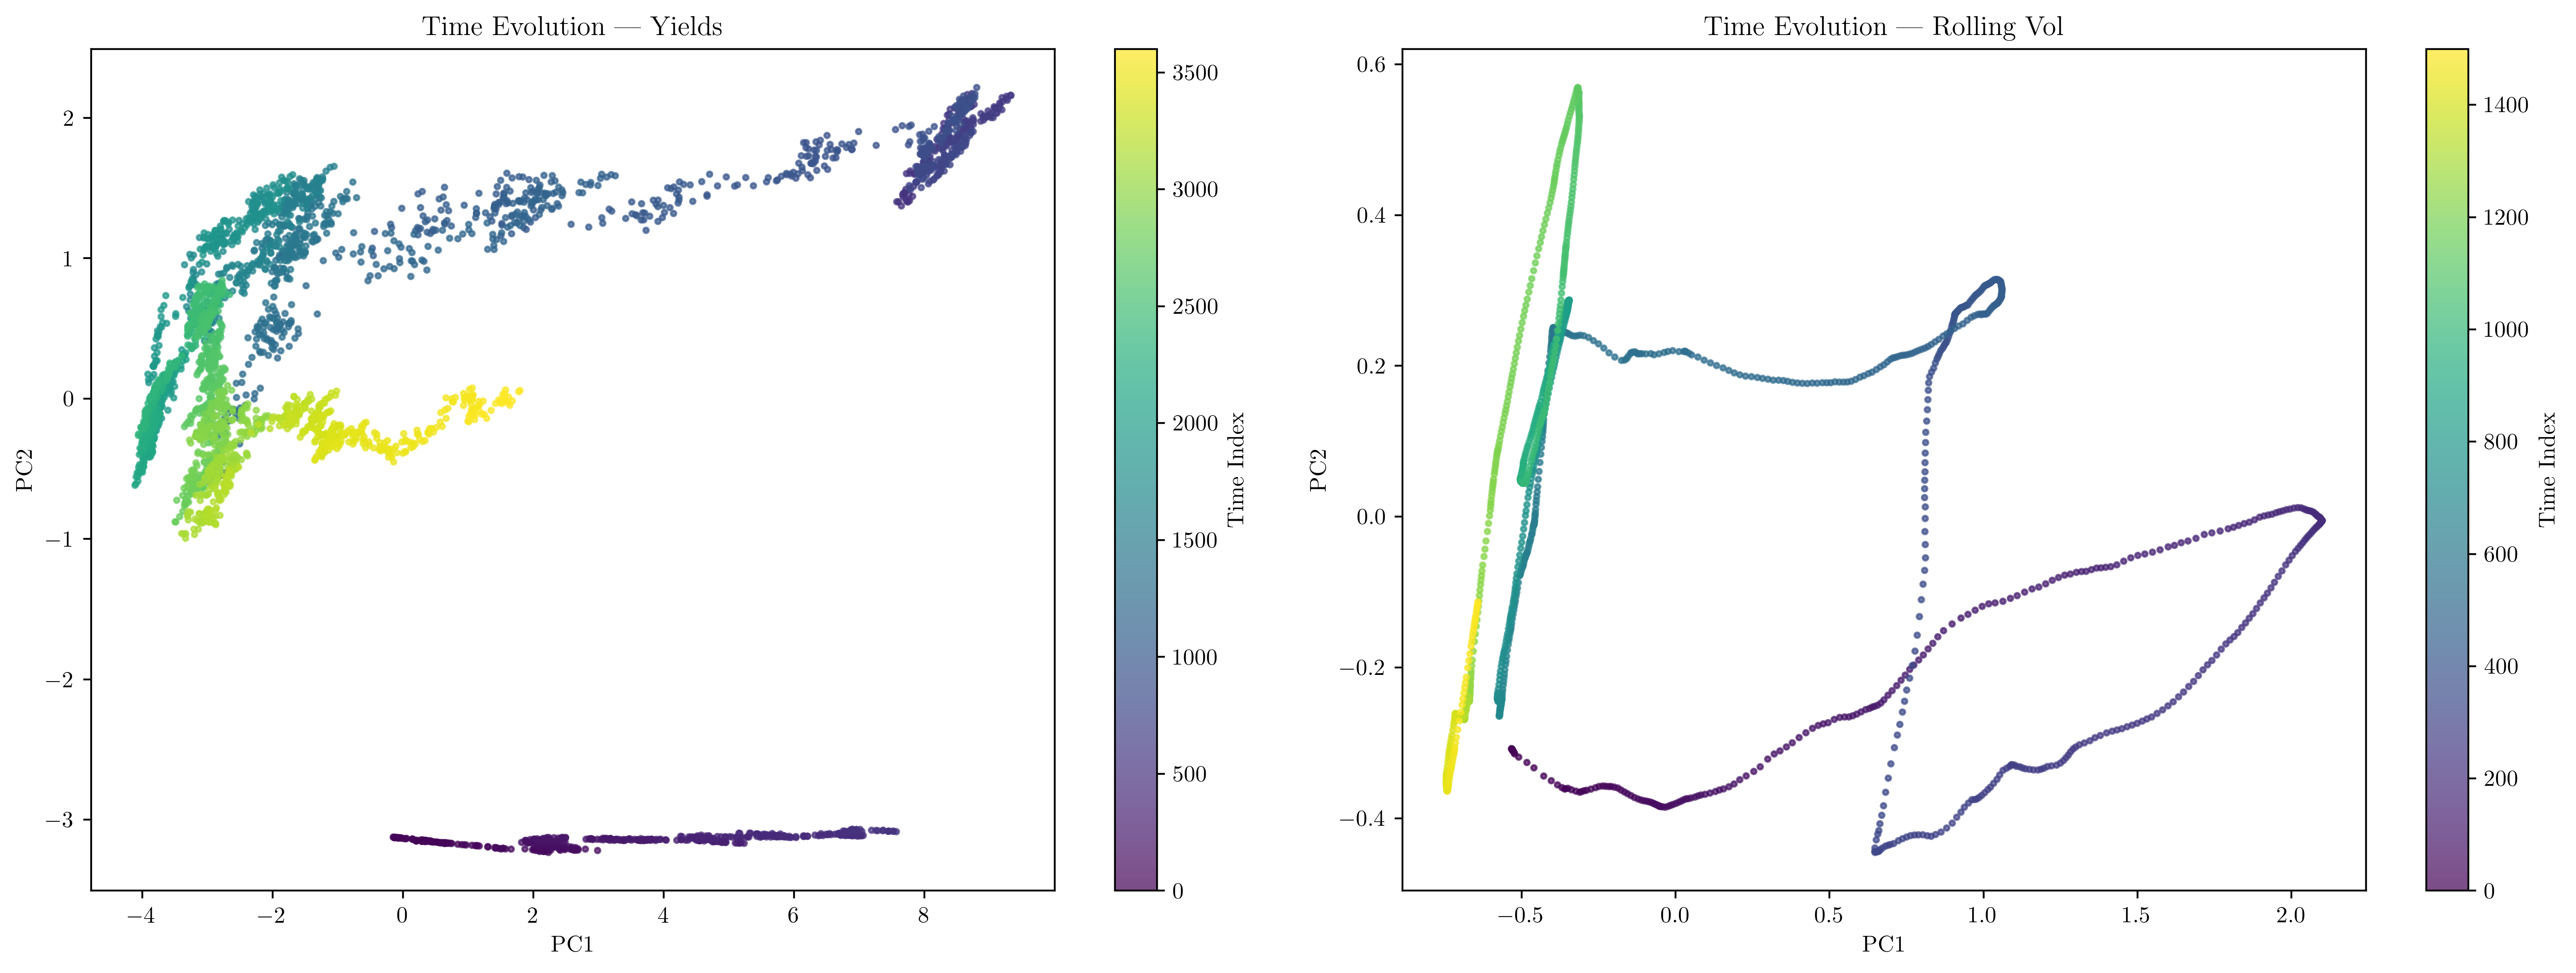

In [22]:
from sklearn.decomposition import PCA

yields_start, yields_n = 4400 - 900, 3600
yields_end = yields_start + yields_n
yields_X = yield_curves.iloc[yields_start:yields_end]
yields_pca = PCA(n_components=2).fit(yields_X)
yields_scores = yields_pca.transform(yields_X)

rolling_vol = yield_curves.rolling(252).std()
vol_start, vol_n = 4400, 1500
vol_end = vol_start + vol_n
vol_X = rolling_vol.iloc[vol_start:vol_end].dropna(axis=0)
vol_pca = PCA(n_components=2).fit(vol_X)
vol_scores = vol_pca.transform(vol_X)

fig, (ax_yields, ax_vol) = plt.subplots(1, 2, figsize=(16, 6))

sc_yields = ax_yields.scatter(yields_scores[:, 0], yields_scores[:, 1], c=np.arange(len(yields_scores)), cmap='viridis', s=5, alpha=0.7)
ax_yields.set_xlabel("PC1")
ax_yields.set_ylabel("PC2")
ax_yields.set_title("Time Evolution — Yields")
plt.colorbar(sc_yields, ax=ax_yields, label="Time Index")

sc_vol = ax_vol.scatter(vol_scores[:, 0], vol_scores[:, 1], c=np.arange(len(vol_scores)), cmap='viridis', s=5, alpha=0.7)
ax_vol.set_xlabel("PC1")
ax_vol.set_ylabel("PC2")
ax_vol.set_title("Time Evolution — Rolling Vol")
plt.colorbar(sc_vol, ax=ax_vol, label="Time Index")

plt.tight_layout()
plt.show()

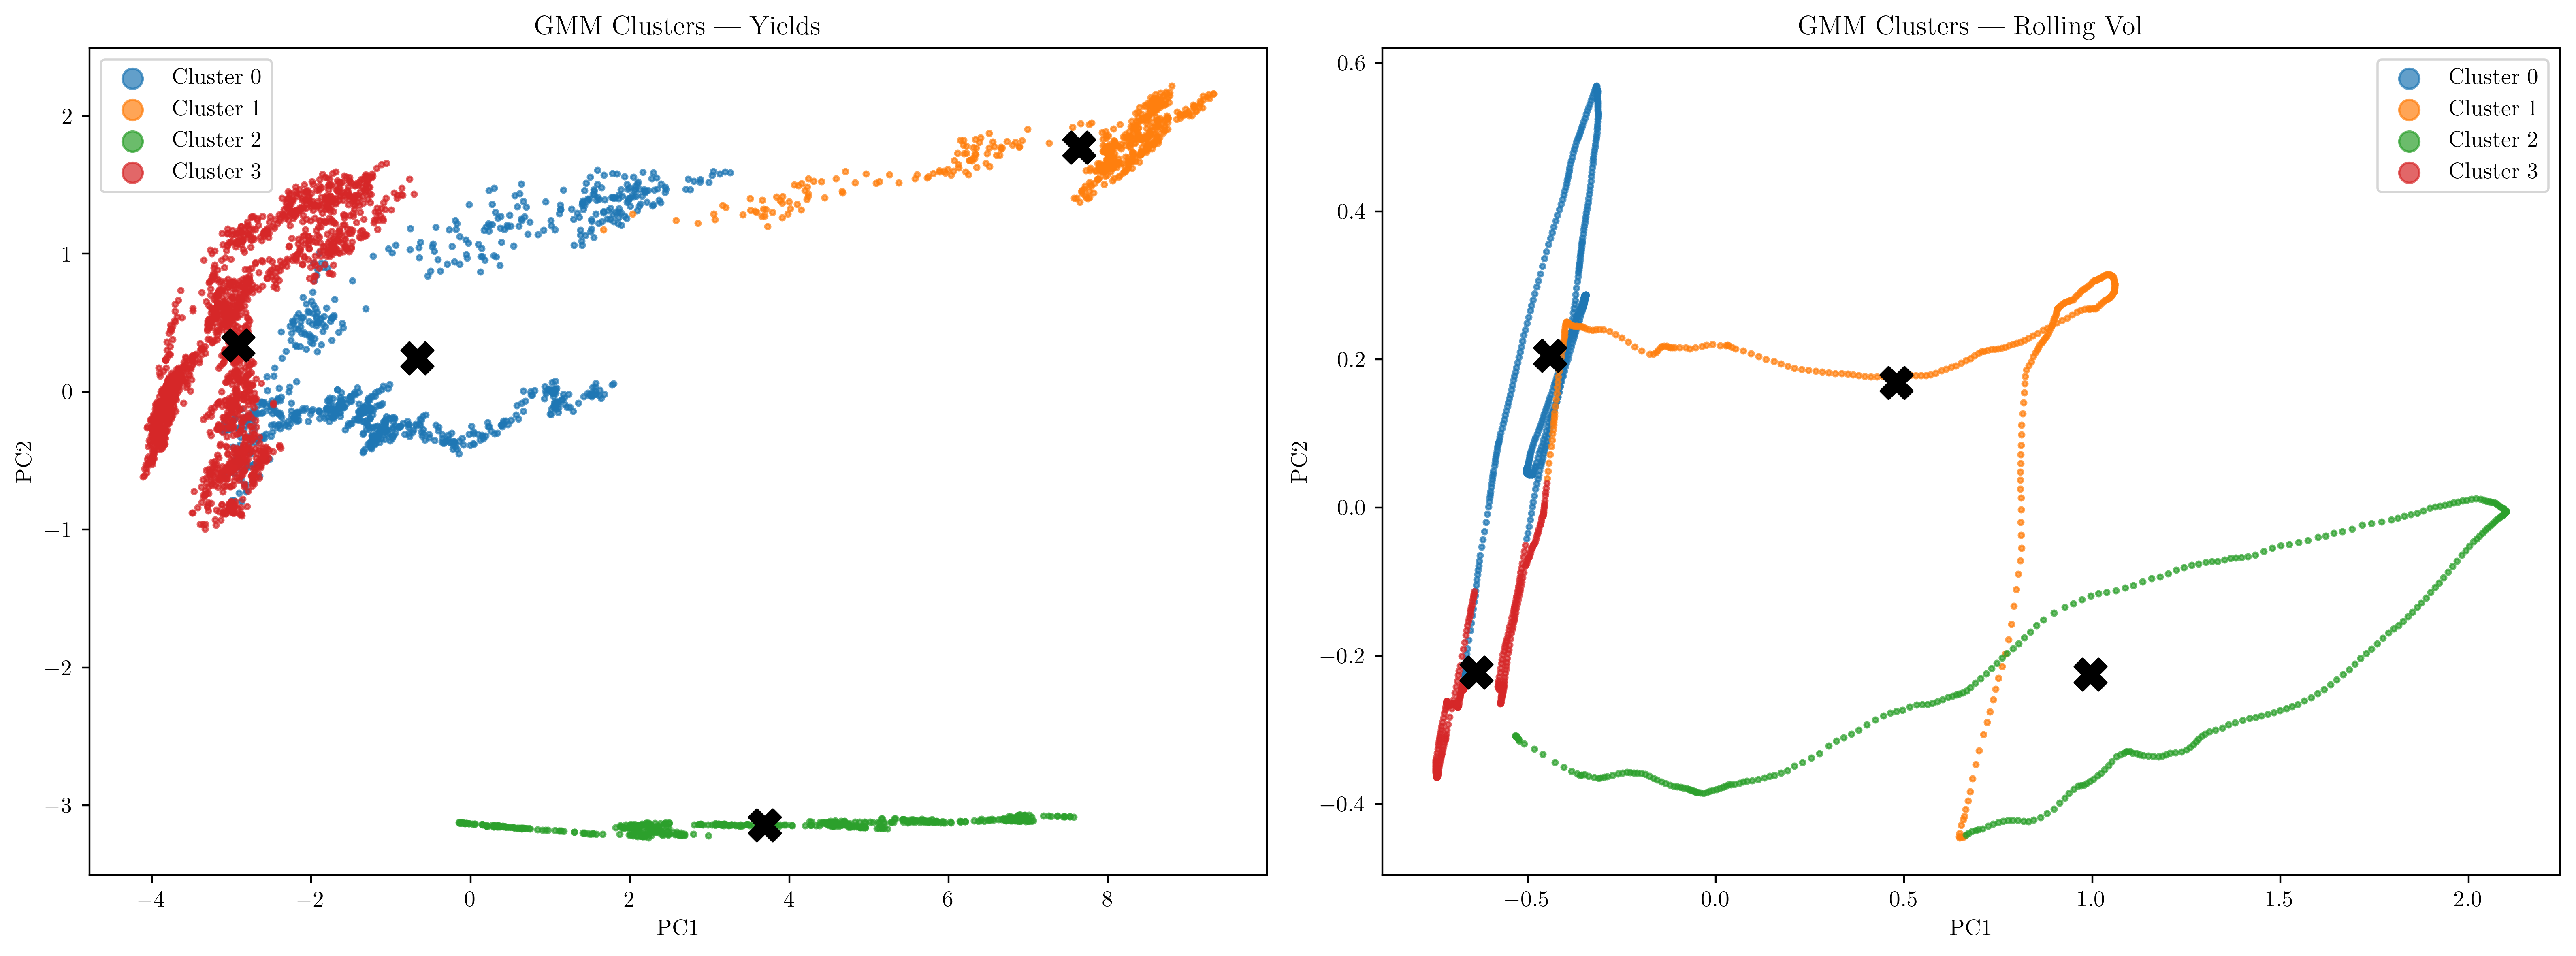

In [23]:
from sklearn.mixture import GaussianMixture

N_CLUSTERS = 4

yields_gmm = GaussianMixture(n_components=N_CLUSTERS, random_state=42).fit(yields_X)
yields_labels = yields_gmm.predict(yields_X)
yields_probs = yields_gmm.predict_proba(yields_X)

vol_gmm = GaussianMixture(n_components=N_CLUSTERS, random_state=42).fit(vol_X)
vol_labels = vol_gmm.predict(vol_X)
vol_probs = vol_gmm.predict_proba(vol_X)

fig, (ax_yields, ax_vol) = plt.subplots(1, 2, figsize=(16, 6))

for k in range(N_CLUSTERS):
    mask = yields_labels == k
    ax_yields.scatter(yields_scores[mask, 0], yields_scores[mask, 1], s=5, alpha=0.7, label=f"Cluster {k}")
yields_centers = yields_pca.transform(yields_gmm.means_)
ax_yields.scatter(yields_centers[:, 0], yields_centers[:, 1], marker='X', s=200, c='black', zorder=10)
ax_yields.set_xlabel("PC1")
ax_yields.set_ylabel("PC2")
ax_yields.set_title("GMM Clusters — Yields")
ax_yields.legend(markerscale=4)

for k in range(N_CLUSTERS):
    mask = vol_labels == k
    ax_vol.scatter(vol_scores[mask, 0], vol_scores[mask, 1], s=5, alpha=0.7, label=f"Cluster {k}")
vol_centers = vol_pca.transform(vol_gmm.means_)
ax_vol.scatter(vol_centers[:, 0], vol_centers[:, 1], marker='X', s=200, c='black', zorder=10)
ax_vol.set_xlabel("PC1")
ax_vol.set_ylabel("PC2")
ax_vol.set_title("GMM Clusters — Rolling Vol")
ax_vol.legend(markerscale=4)

plt.tight_layout()
plt.show()

We can see for the first time that the cluster centers are different. How we cluster, on what data we cluster makes a big difference. Clustering directly on volatility produces vastly different results then clustering directly on yields.

Can you think of some other ideas on how we can cluster the data points? Can you do this? (R)

## Spreads
- What statistical property do they follow?
- Can you formalise with any specific form of statistic test?

## Curve shape math

Define level, slope, and curvature from key tenors (2y, 5y, 10y):

- **Slope** (10y − 2y): steepening/flattening.
- **Curvature** (2·5y − 2y − 10y): belly vs wings (zero for a straight line).
- **Butterfly** (2y − 2·5y + 10y): duration‑neutral curvature trade.

Rolling z-scores (e.g. 252d) show how many standard deviations each measure is from its recent mean.

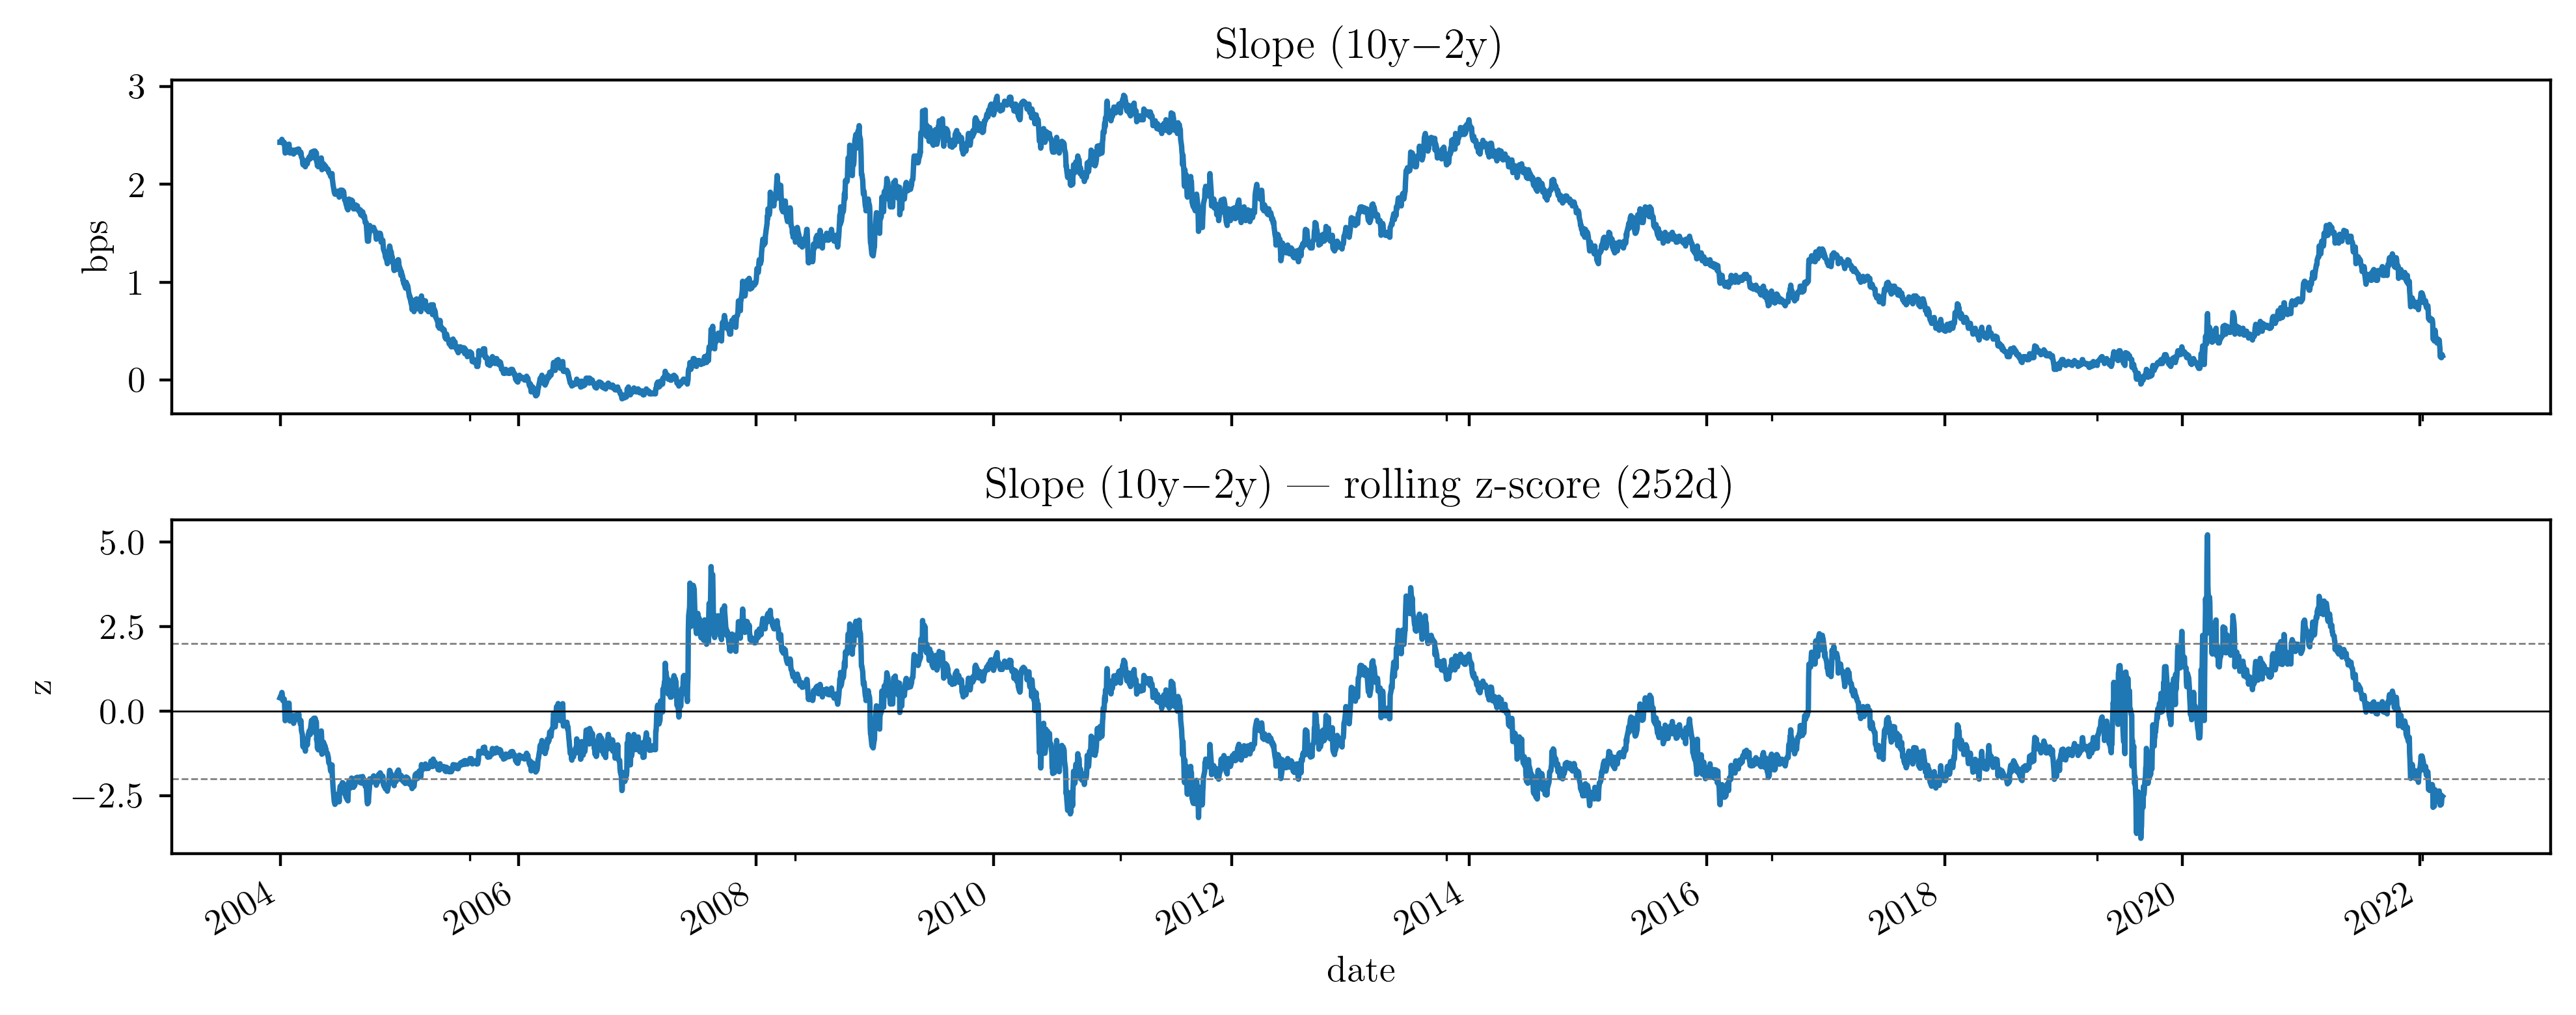

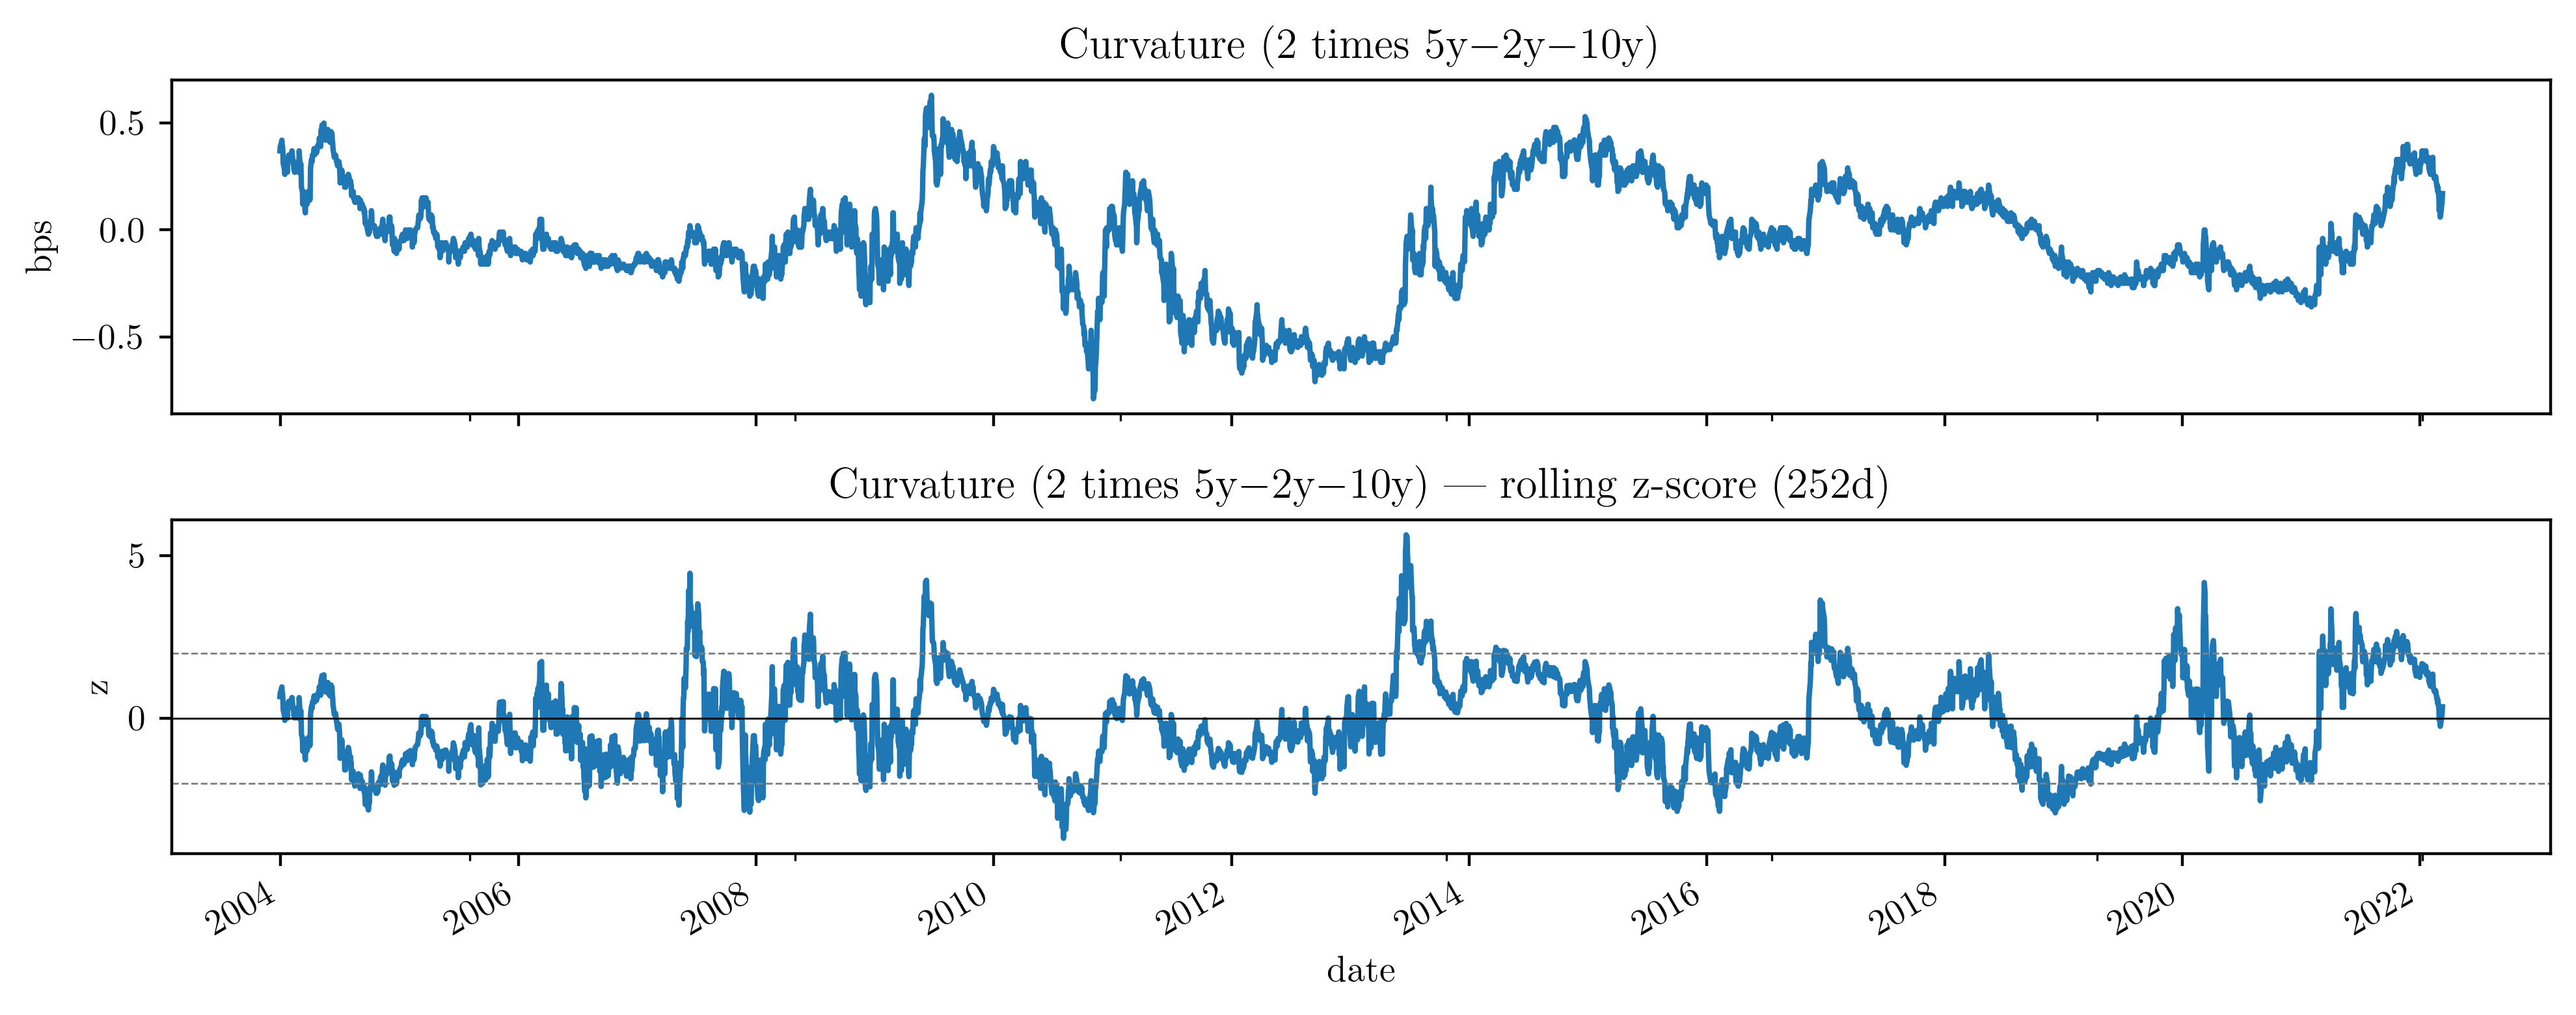

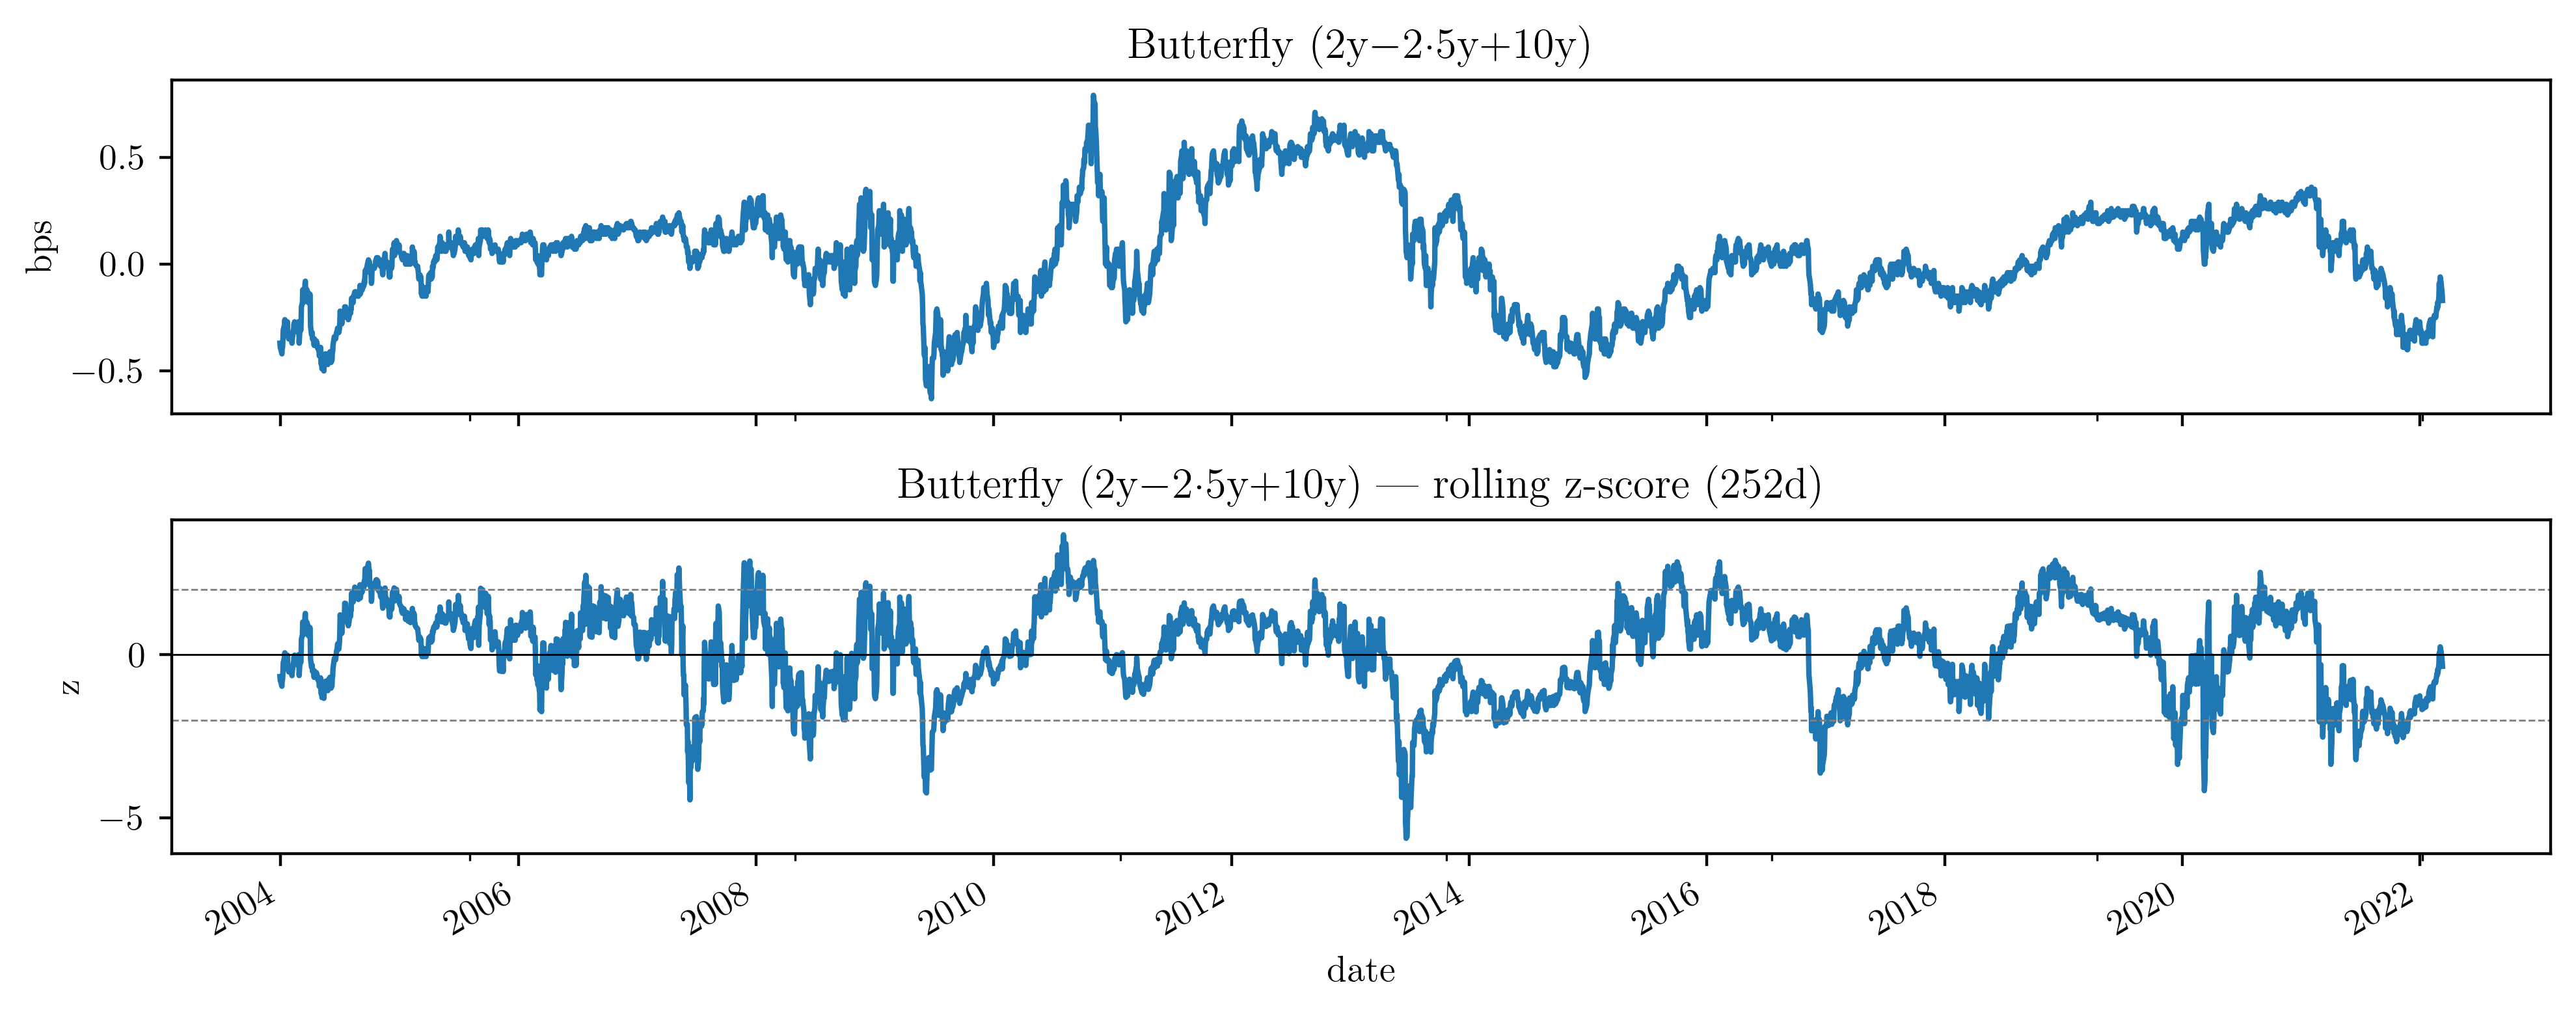

In [27]:
y2 = yield_curves[2]
y5 = yield_curves[5]
y10 = yield_curves[10]

slope = y10 - y2
curvature = 2 * y5 - y2 - y10
butterfly = y2 - 2 * y5 + y10

window = 252
for name, series in [("Slope (10y−2y)", slope), (f"Curvature (2 times 5y−2y−10y)", curvature), ("Butterfly (2y−2·5y+10y)", butterfly)]:
    roll_mean = series.rolling(window).mean()
    roll_std = series.rolling(window).std()
    z = (series - roll_mean) / roll_std

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
    series.loc[series.index[start_idx]:].plot(ax=axes[0], title=name)
    axes[0].set_ylabel("bps")
    z.loc[z.index[start_idx]:].plot(ax=axes[1], title=f"{name} — rolling z-score ({window}d)")
    axes[1].axhline(0, color="k", lw=0.5)
    axes[1].axhline(2, color="gray", ls="--", lw=0.5)
    axes[1].axhline(-2, color="gray", ls="--", lw=0.5)
    axes[1].set_ylabel("z")
    plt.tight_layout()
    plt.show()

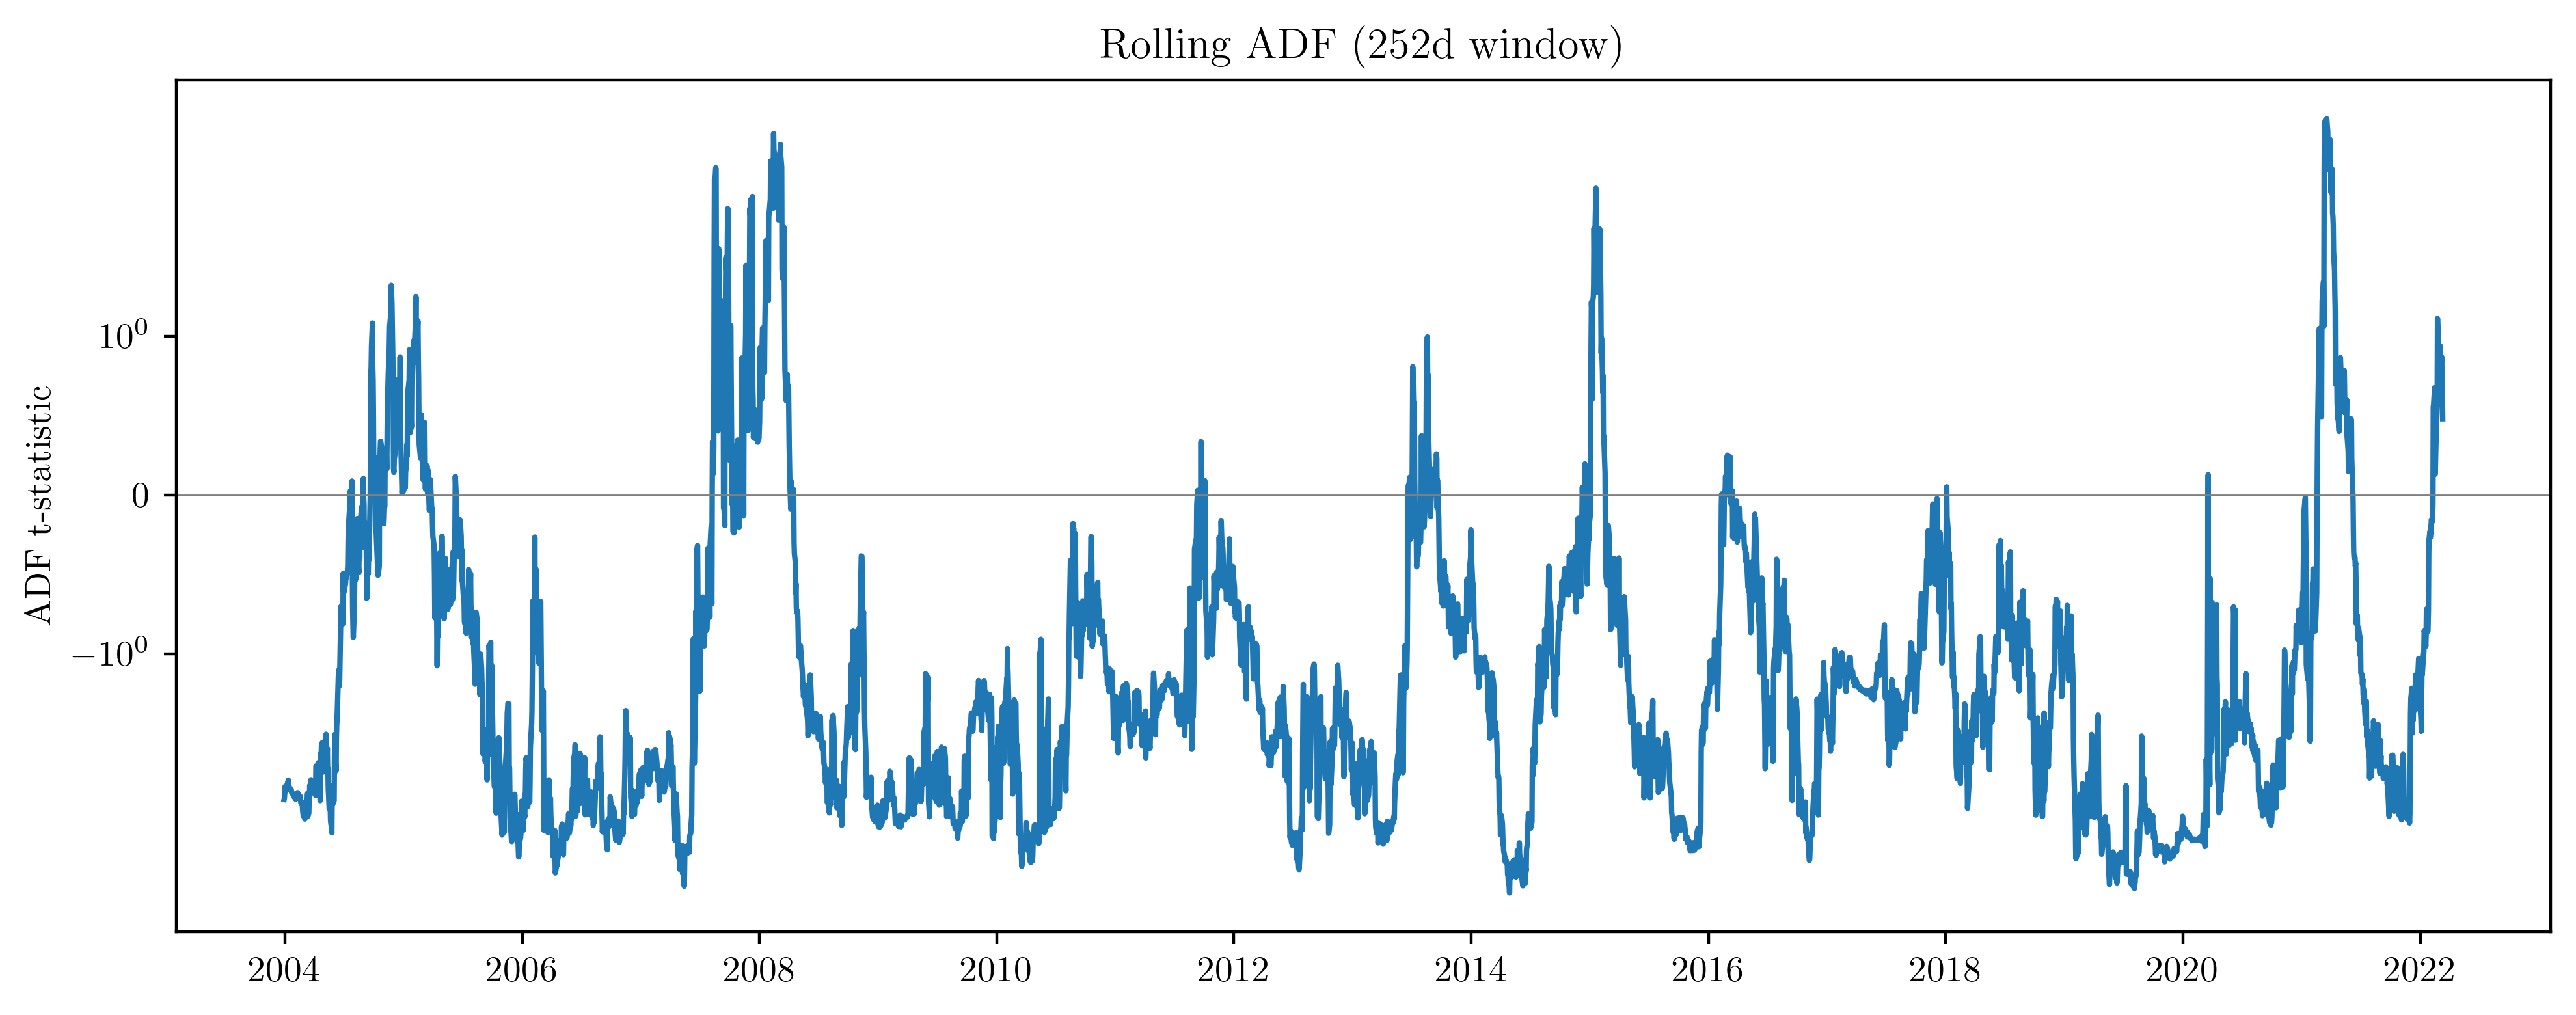

In [29]:
from statsmodels.tsa.stattools import adfuller

def rolling_adf(series, window=252):
    stat = np.full(len(series), np.nan)
    for i in range(window, len(series) + 1):
        stat[i - 1] = adfuller(series.iloc[i - window : i], autolag="AIC")[0]
    return pd.Series(stat, index=series.index)

adf_stat = rolling_adf(slope, window=252)  # or yield_curves[10], curvature, etc.

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(adf_stat.loc[adf_stat.index[start_idx]:])
ax.set_yscale("symlog")
ax.axhline(0, color="gray", lw=0.5)
ax.set_ylabel("ADF t-statistic")
ax.set_title("Rolling ADF (252d window)")
fig.tight_layout()
plt.show()

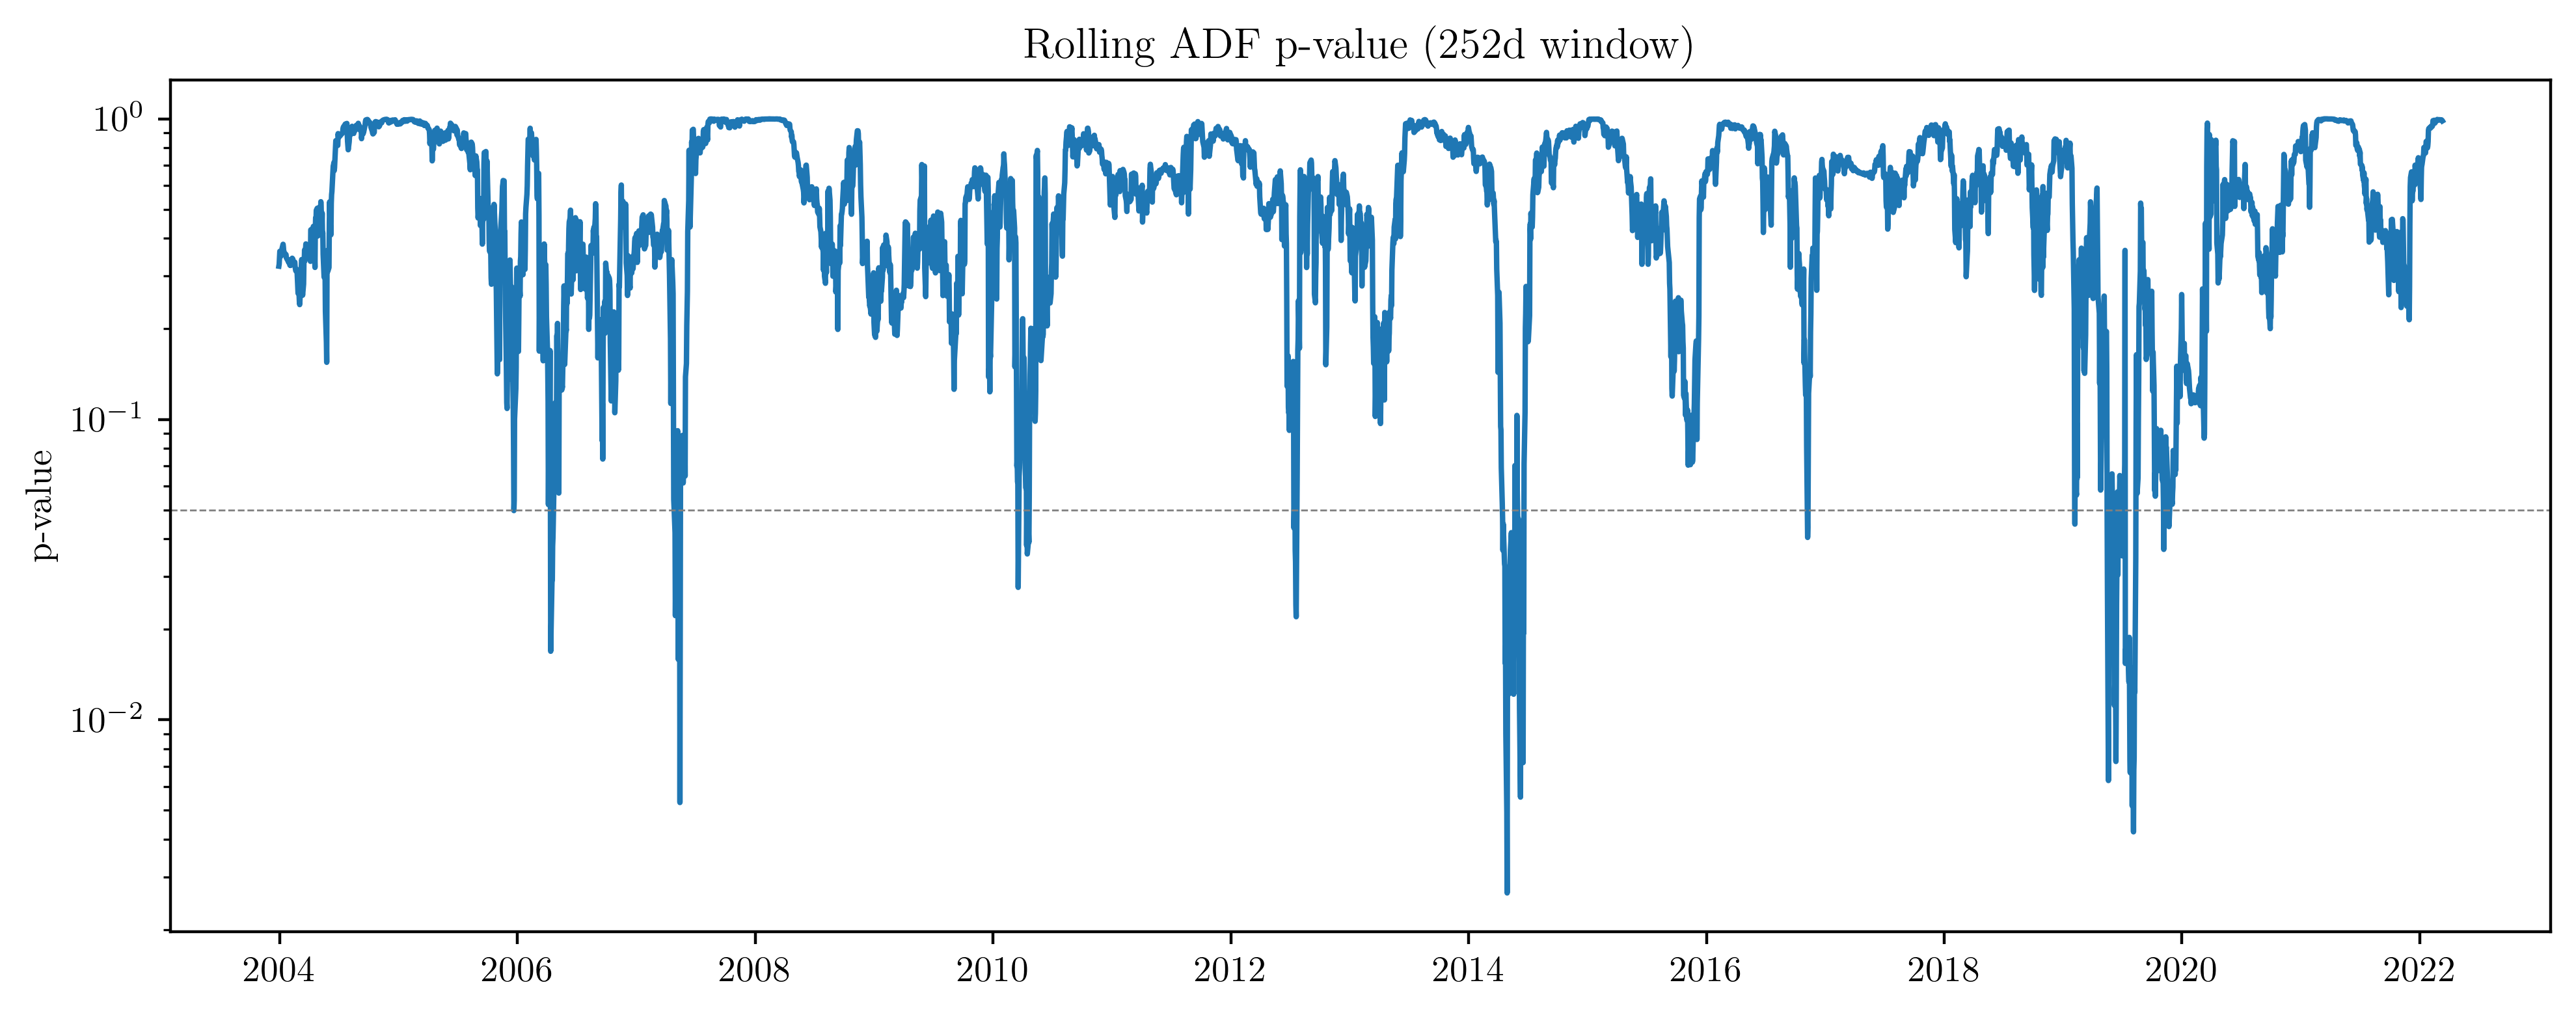

In [30]:
from statsmodels.tsa.stattools import adfuller

def rolling_adf_pval(series, window=252):
    pval = np.full(len(series), np.nan)
    for i in range(window, len(series) + 1):
        pval[i - 1] = adfuller(series.iloc[i - window : i], autolag="AIC")[1]
    return pd.Series(pval, index=series.index)

pval = rolling_adf_pval(slope, window=252)

fig, ax = plt.subplots(figsize=(10, 4))
ax.semilogy(pval.loc[pval.index[start_idx]:])
ax.axhline(0.05, color="gray", linestyle="--", lw=0.5)
ax.set_ylabel("p-value")
ax.set_title("Rolling ADF p-value (252d window)")
fig.tight_layout()
plt.show()